In [3]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import os,sys
import fitsio as fio
import matplotlib as mpl
from tqdm import tqdm
import proplot as pplt
import pickle
%matplotlib inline

# Set a path to the metadetect and pizza-cutter files.

In [3]:
work_mdet = '/global/project/projectdirs/des/myamamot/metadetect'
work_pizza = '/global/cscratch1/sd/myamamot/pizza-slice/griz'
f = open(os.path.join(work_mdet, 'mdet_files.txt'), 'r')
fs = f.read().split('\n')[:-1]

In [5]:
d_one = fio.read(os.path.join(work_mdet, fs[0]))
d_one.dtype

dtype([('slice_id', '>i8'), ('mdet_step', '<U7'), ('ra', '>f8'), ('dec', '>f8'), ('ra_noshear', '>f8'), ('dec_noshear', '>f8'), ('y_noshear', '>f8'), ('x_noshear', '>f8'), ('y', '>f8'), ('x', '>f8'), ('slice_y', '>f8'), ('slice_x', '>f8'), ('slice_y_noshear', '>f8'), ('slice_x_noshear', '>f8'), ('hpix_16384', '>i8'), ('hpix_16384_noshear', '>i8'), ('filename', '<U48'), ('tilename', '<U12'), ('flags', '>i4'), ('psf_flags', '>i4'), ('psf_g_1', '>f8'), ('psf_g_2', '>f8'), ('psf_T', '>f8'), ('mdet_flags', '>i4'), ('mdet_s2n', '>f8'), ('mdet_g_1', '>f8'), ('mdet_g_2', '>f8'), ('mdet_g_cov_1_1', '>f8'), ('mdet_g_cov_1_2', '>f8'), ('mdet_g_cov_2_2', '>f8'), ('mdet_T', '>f8'), ('mdet_T_err', '>f8'), ('mdet_T_ratio', '>f8'), ('ormask', '>i4'), ('mfrac', '>f4'), ('bmask', '>i4'), ('mask_flags', '>i4'), ('ormask_noshear', '>i4'), ('mfrac_noshear', '>f4'), ('bmask_noshear', '>i4'), ('mask_flags_noshear', '>i4'), ('psfrec_flags', '>i4'), ('psfrec_g_1', '>f8'), ('psfrec_g_2', '>f8'), ('psfrec_T', '>

# Catalog Masking Example!

In [1]:
import healsparse
import healpy as hp
import skyproj
hmap = healsparse.HealSparseMap.read('/global/project/projectdirs/des/myamamot/metadetect/y6-combined-hsmap16384-nomdet.fits')

In [ ]:
# Boolean values for ra, dec are in the mask. 
# hmap.get_values.pos(ra, dec, valid_mask=True)

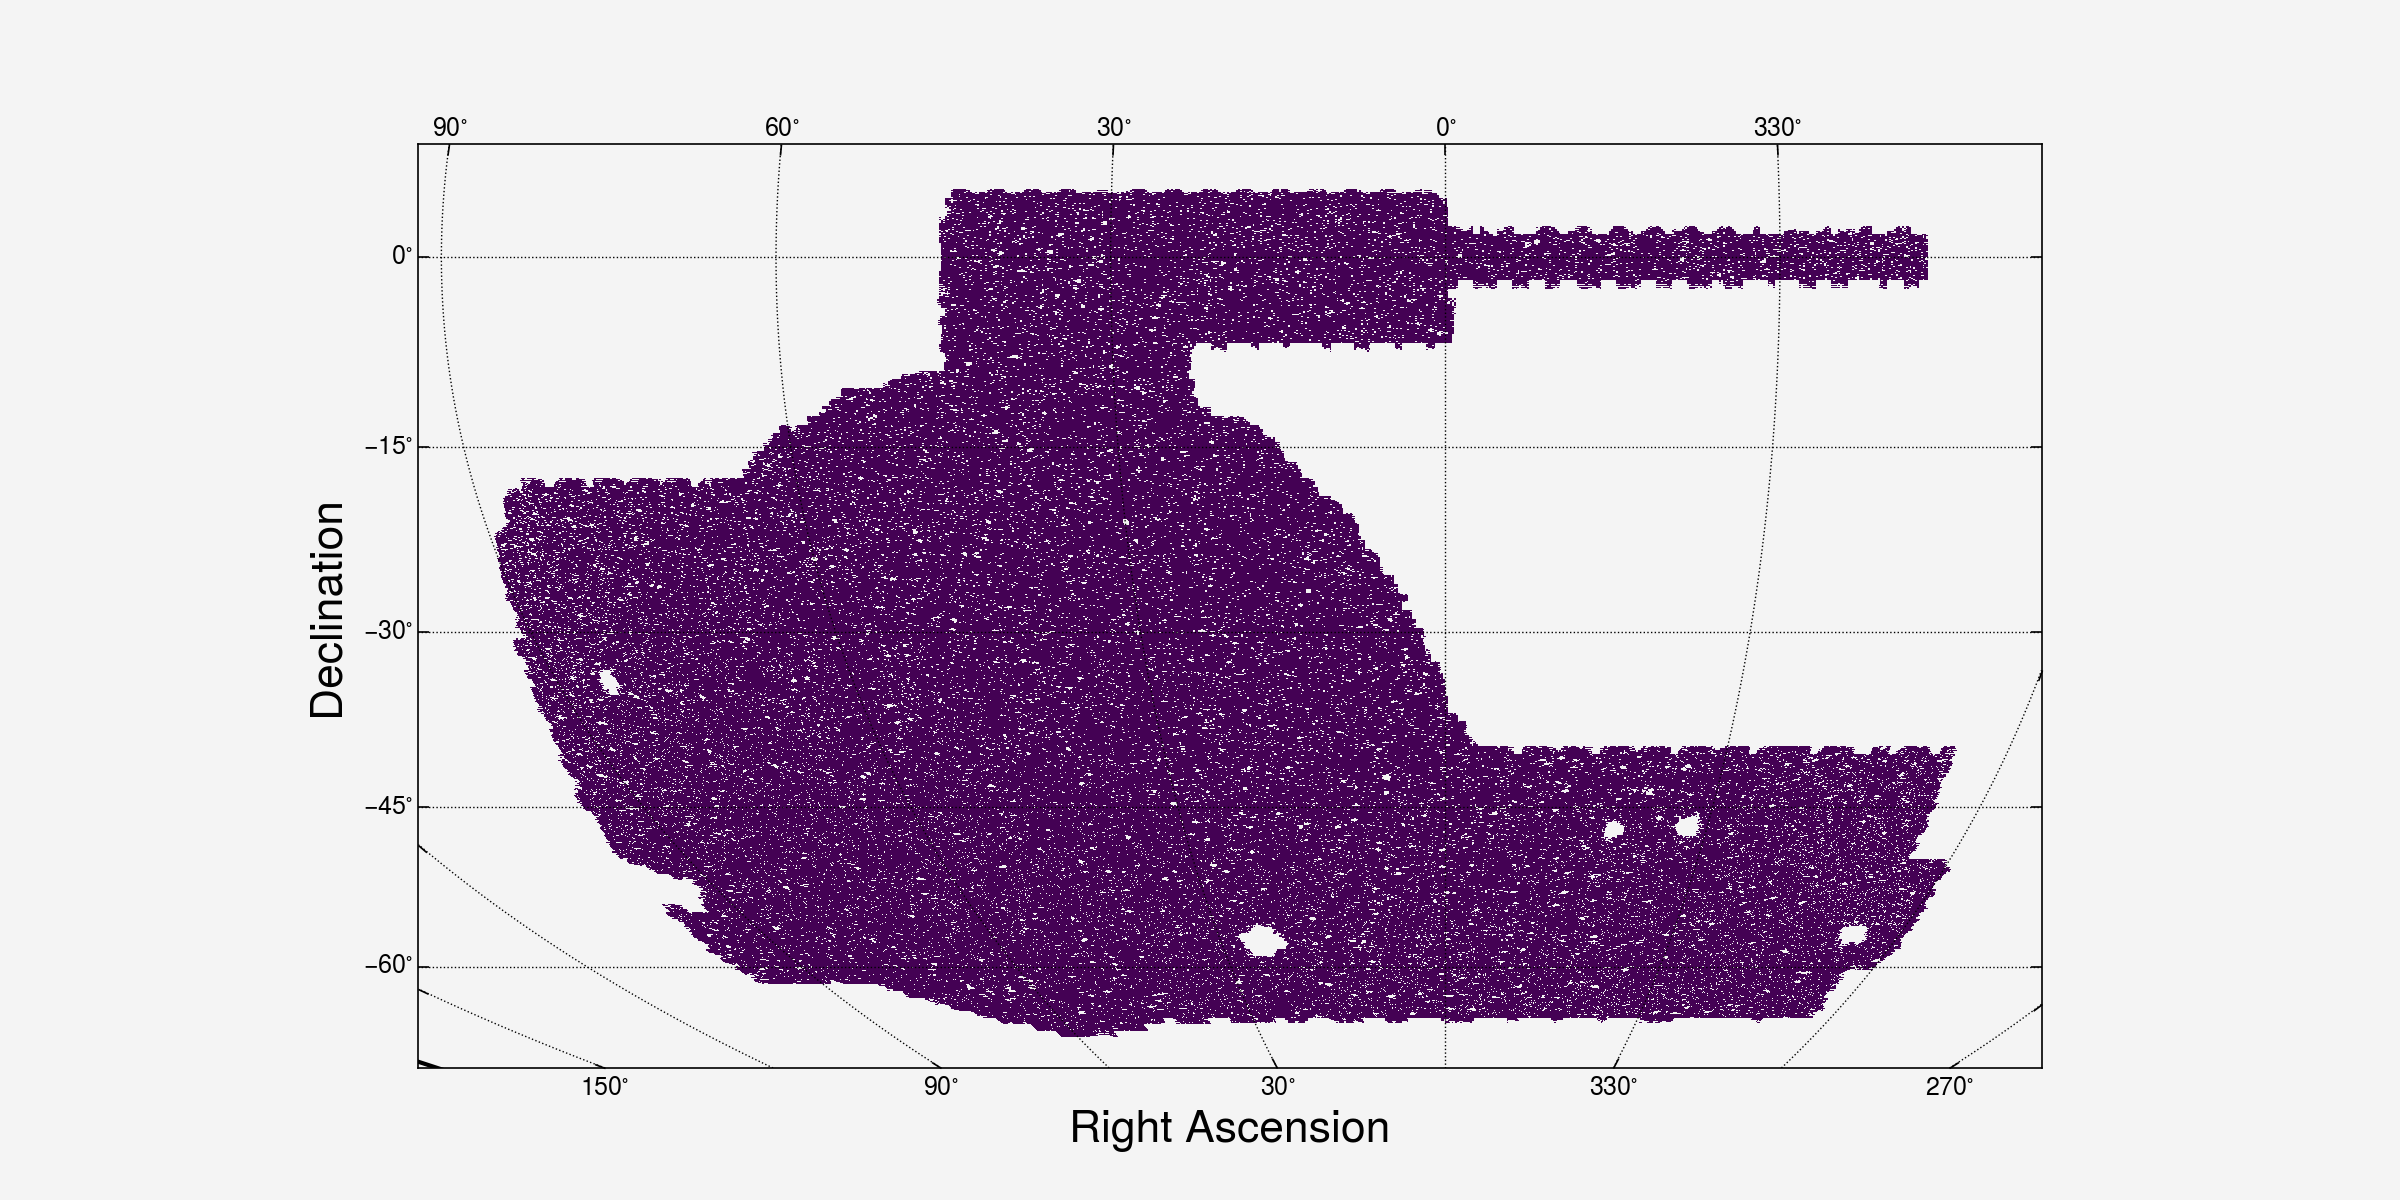

In [4]:
fig,ax = plt.subplots(figsize=(12,6))
m = skyproj.McBrydeSkyproj(ax=ax, autorescale=False)
_ = m.draw_hspmap(hmap, cmap='viridis')

In [7]:
# Choose random points within the mask. 
ra_rand, dec_rand = healsparse.make_uniform_randoms_fast(hmap, 262000)
rand_pos = np.zeros(262000, dtype=[('ra', float), ('dec', float)])
d = np.stack([ra_rand, dec_rand], axis=1)
rand_pos['ra'] = d[:,0]
rand_pos['dec'] = d[:,1]
fio.write('y6-combined-hsmap_random.fits', rand_pos)

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-4-1e063c69b9ff>:8: RuntimeWarning: invalid value encountered in log10
  mag_g = 30.0 - 2.5*np.log10(d["mdet_g_flux"])
<ipython-input-4-1e063c69b9ff>:9: RuntimeWarning: invalid value encountered in log10
  mag_r = 30.0 - 2.5*np.log10(d["mdet_r_flux"])
<ipython-input-4-1e063c69b9ff>:10: RuntimeWarning: invalid value encountered in log10
  mag_i = 30.0 - 2.5*np.log10(d["mdet_i_flux"])
<ipython-input-4-1e063c69b9ff>:11: RuntimeWarning: invalid value encountered in log10
  mag_z = 30.0 - 2.5*np.log10(d["mdet_z_flux"])
100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


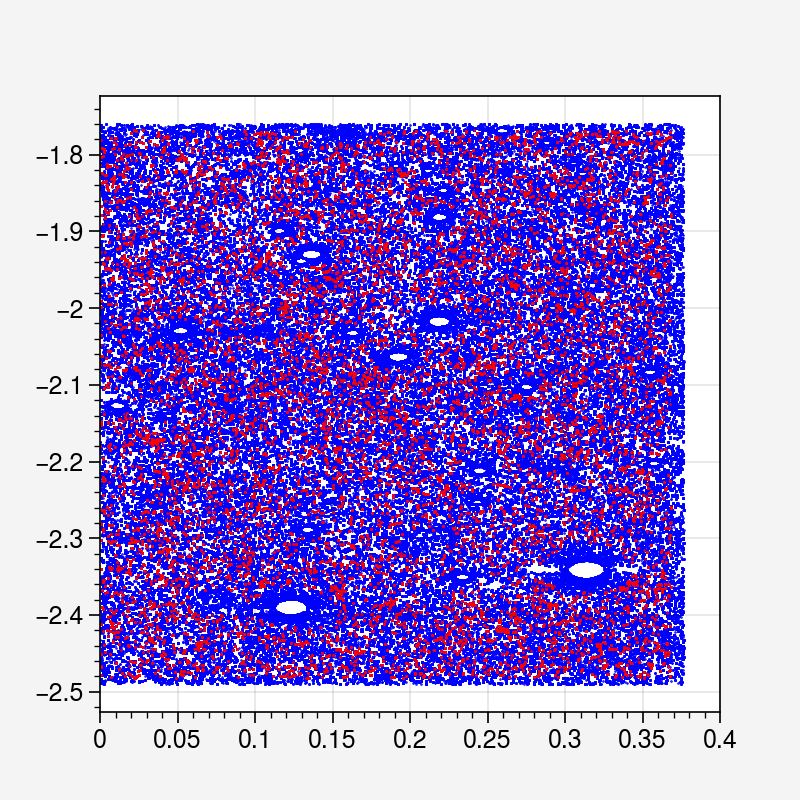

In [4]:
f = open('/global/project/projectdirs/des/myamamot/metadetect/mdet_files.txt', 'r')
fs = f.read().split('\n')[:-1]
mdet_filenames = [fname.split('/')[-1] for fname in fs]
tilenames = [d.split('_')[0] for d in mdet_filenames]

for fname in tqdm(mdet_filenames[0:1]):
    d = fio.read(os.path.join('/global/project/projectdirs/des/myamamot/metadetect', fname))
    mag_g = 30.0 - 2.5*np.log10(d["mdet_g_flux"])
    mag_r = 30.0 - 2.5*np.log10(d["mdet_r_flux"])
    mag_i = 30.0 - 2.5*np.log10(d["mdet_i_flux"])
    mag_z = 30.0 - 2.5*np.log10(d["mdet_z_flux"])
    gmr = mag_g - mag_r
    rmi = mag_r - mag_i
    imz = mag_i - mag_z

    msk = ((d["flags"] == 0) & (d["mask_flags"] == 0) & (d["mdet_flux_flags"] == 0) & (d["mdet_T_ratio"] > 0.5) & (d["mdet_s2n"] > 10) & (d["mfrac"] < 0.1) 
            & (d["mdet_T"] < 1.9 - 2.8*d["mdet_T_err"]) & (np.abs(gmr) < 5) & (np.abs(rmi) < 5) & (np.abs(imz) < 5) & np.isfinite(mag_g) & np.isfinite(mag_r) 
            & np.isfinite(mag_i) & np.isfinite(mag_z) & (mag_g < 26.5) & (mag_r < 26.5) & (mag_i < 26.2) & (mag_z < 25.6))
    in_footprint = hmap.get_values_pos(d["ra"], d["dec"], valid_mask=True)

    total_msk = (msk & in_footprint)
    d_msk = d[total_msk]

plt.scatter(d['ra'], d['dec'], color='b', s=0.1)
plt.scatter(d_msk['ra'], d_msk['dec'], color='r', s=0.1)
plt.xlim(0,0.4)
plt.show()

# 1. Number count, RMS of shear, shear response, shear weight as a function of S/N and T_ratio

(array([1.514e+03, 1.560e+03, 1.417e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([2.50787651, 2.50804263, 2.50820874, ..., 7.49099208, 7.49115819,
        7.49132431]),
 <a list of 1 Polygon objects>)

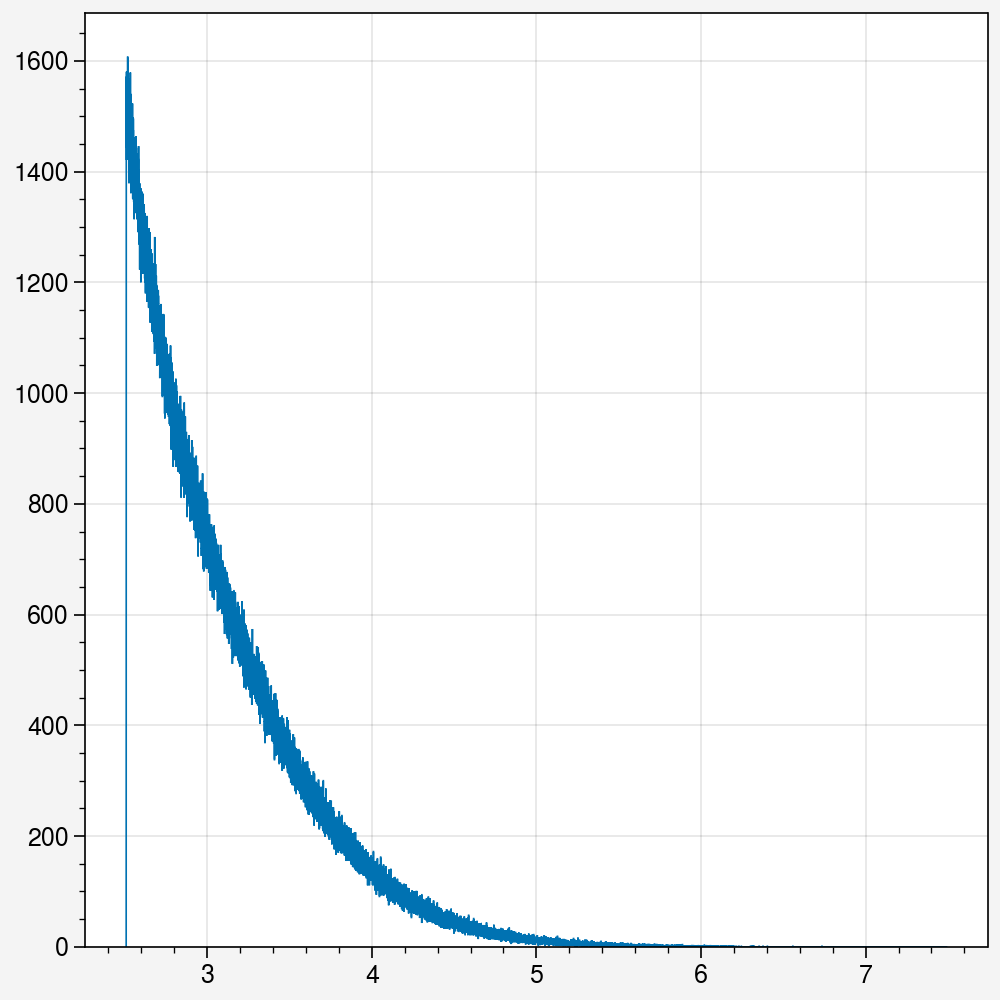

In [43]:
new_d = []
for fname in mdet_filenames:
    d = fio.read(os.path.join('/global/project/projectdirs/des/myamamot/metadetect/cuts_v2/', fname))
    msk = ((d['mdet_T_ratio'] > bins[18])) #& (d['mdet_T_ratio'] < bins[19]))
    d_msk = d[msk]
    new_d.append(d_msk)
new_d = np.concatenate(new_d, axis=0)
fig = pplt.figure(figsize=(5,5), sharex=False, sharey=False)
ax = fig.subplots(nrows=1, ncols=1)
ax.hist(new_d['mdet_T_ratio'], bins=30000, histtype='step')

<ipython-input-56-9e6cee9e12d0>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,100)


Text(0.5, 0, 'S/N')

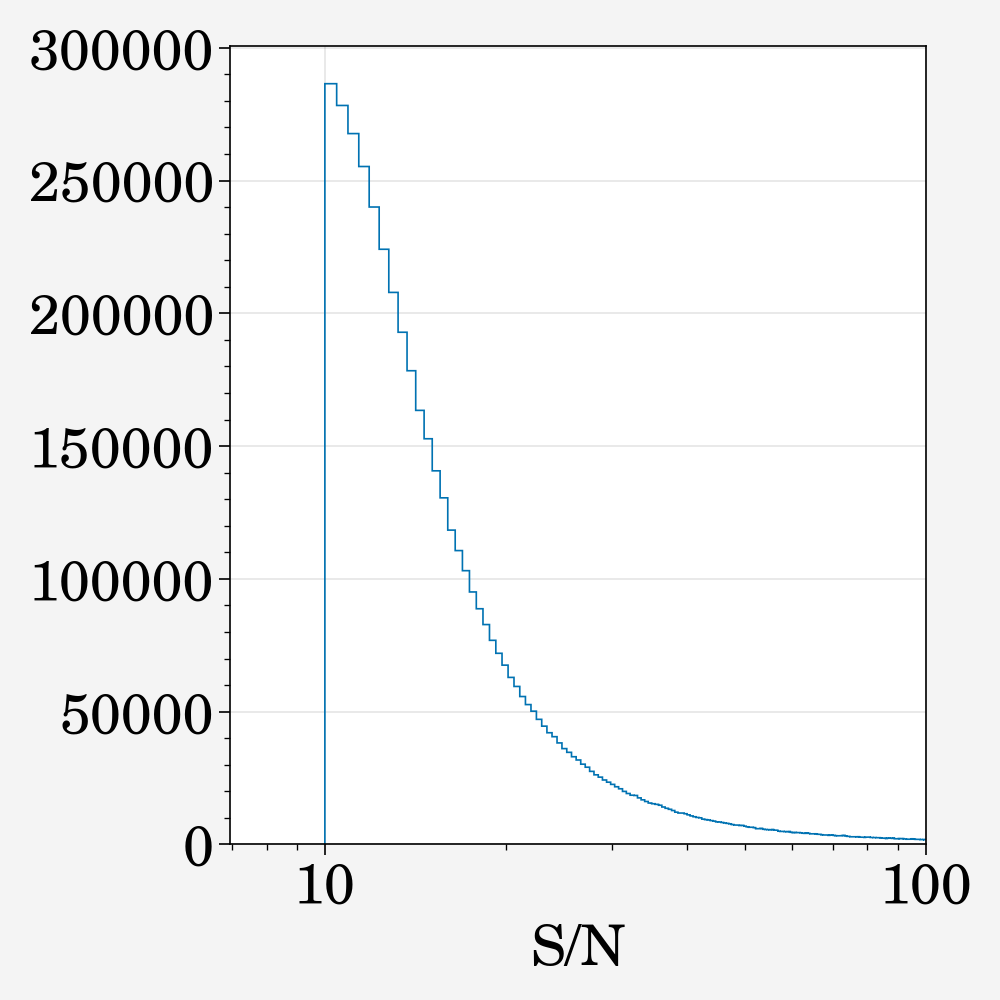

In [56]:
fig = pplt.figure(figsize=(5,5), sharex=False, sharey=False)
ax = fig.subplots(nrows=1, ncols=1)
ax.hist(new_d['mdet_s2n'], bins=30000, histtype='step')
ax.set_xscale('log')
ax.set_xlim(0,100)
ax.set_xlabel('S/N')

max T ratio 2.999946332119132 DES2230-4206_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.99830561552379 DES2330-4414_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.999791229873277 DES0009+0418_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.9984122972017713 DES2235-4706_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.9997615454942075 DES0103-1832_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.999646493766602 DES2341-5331_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.9976543847079644 DES2308-4249_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.9983265245532564 DES0135+0500_metadetect-v5_mdetcat_part0000.fits
max T ratio 2.9999511406747983 DES2356-4914_metadetect-v5_mdetcat_part0000.fits


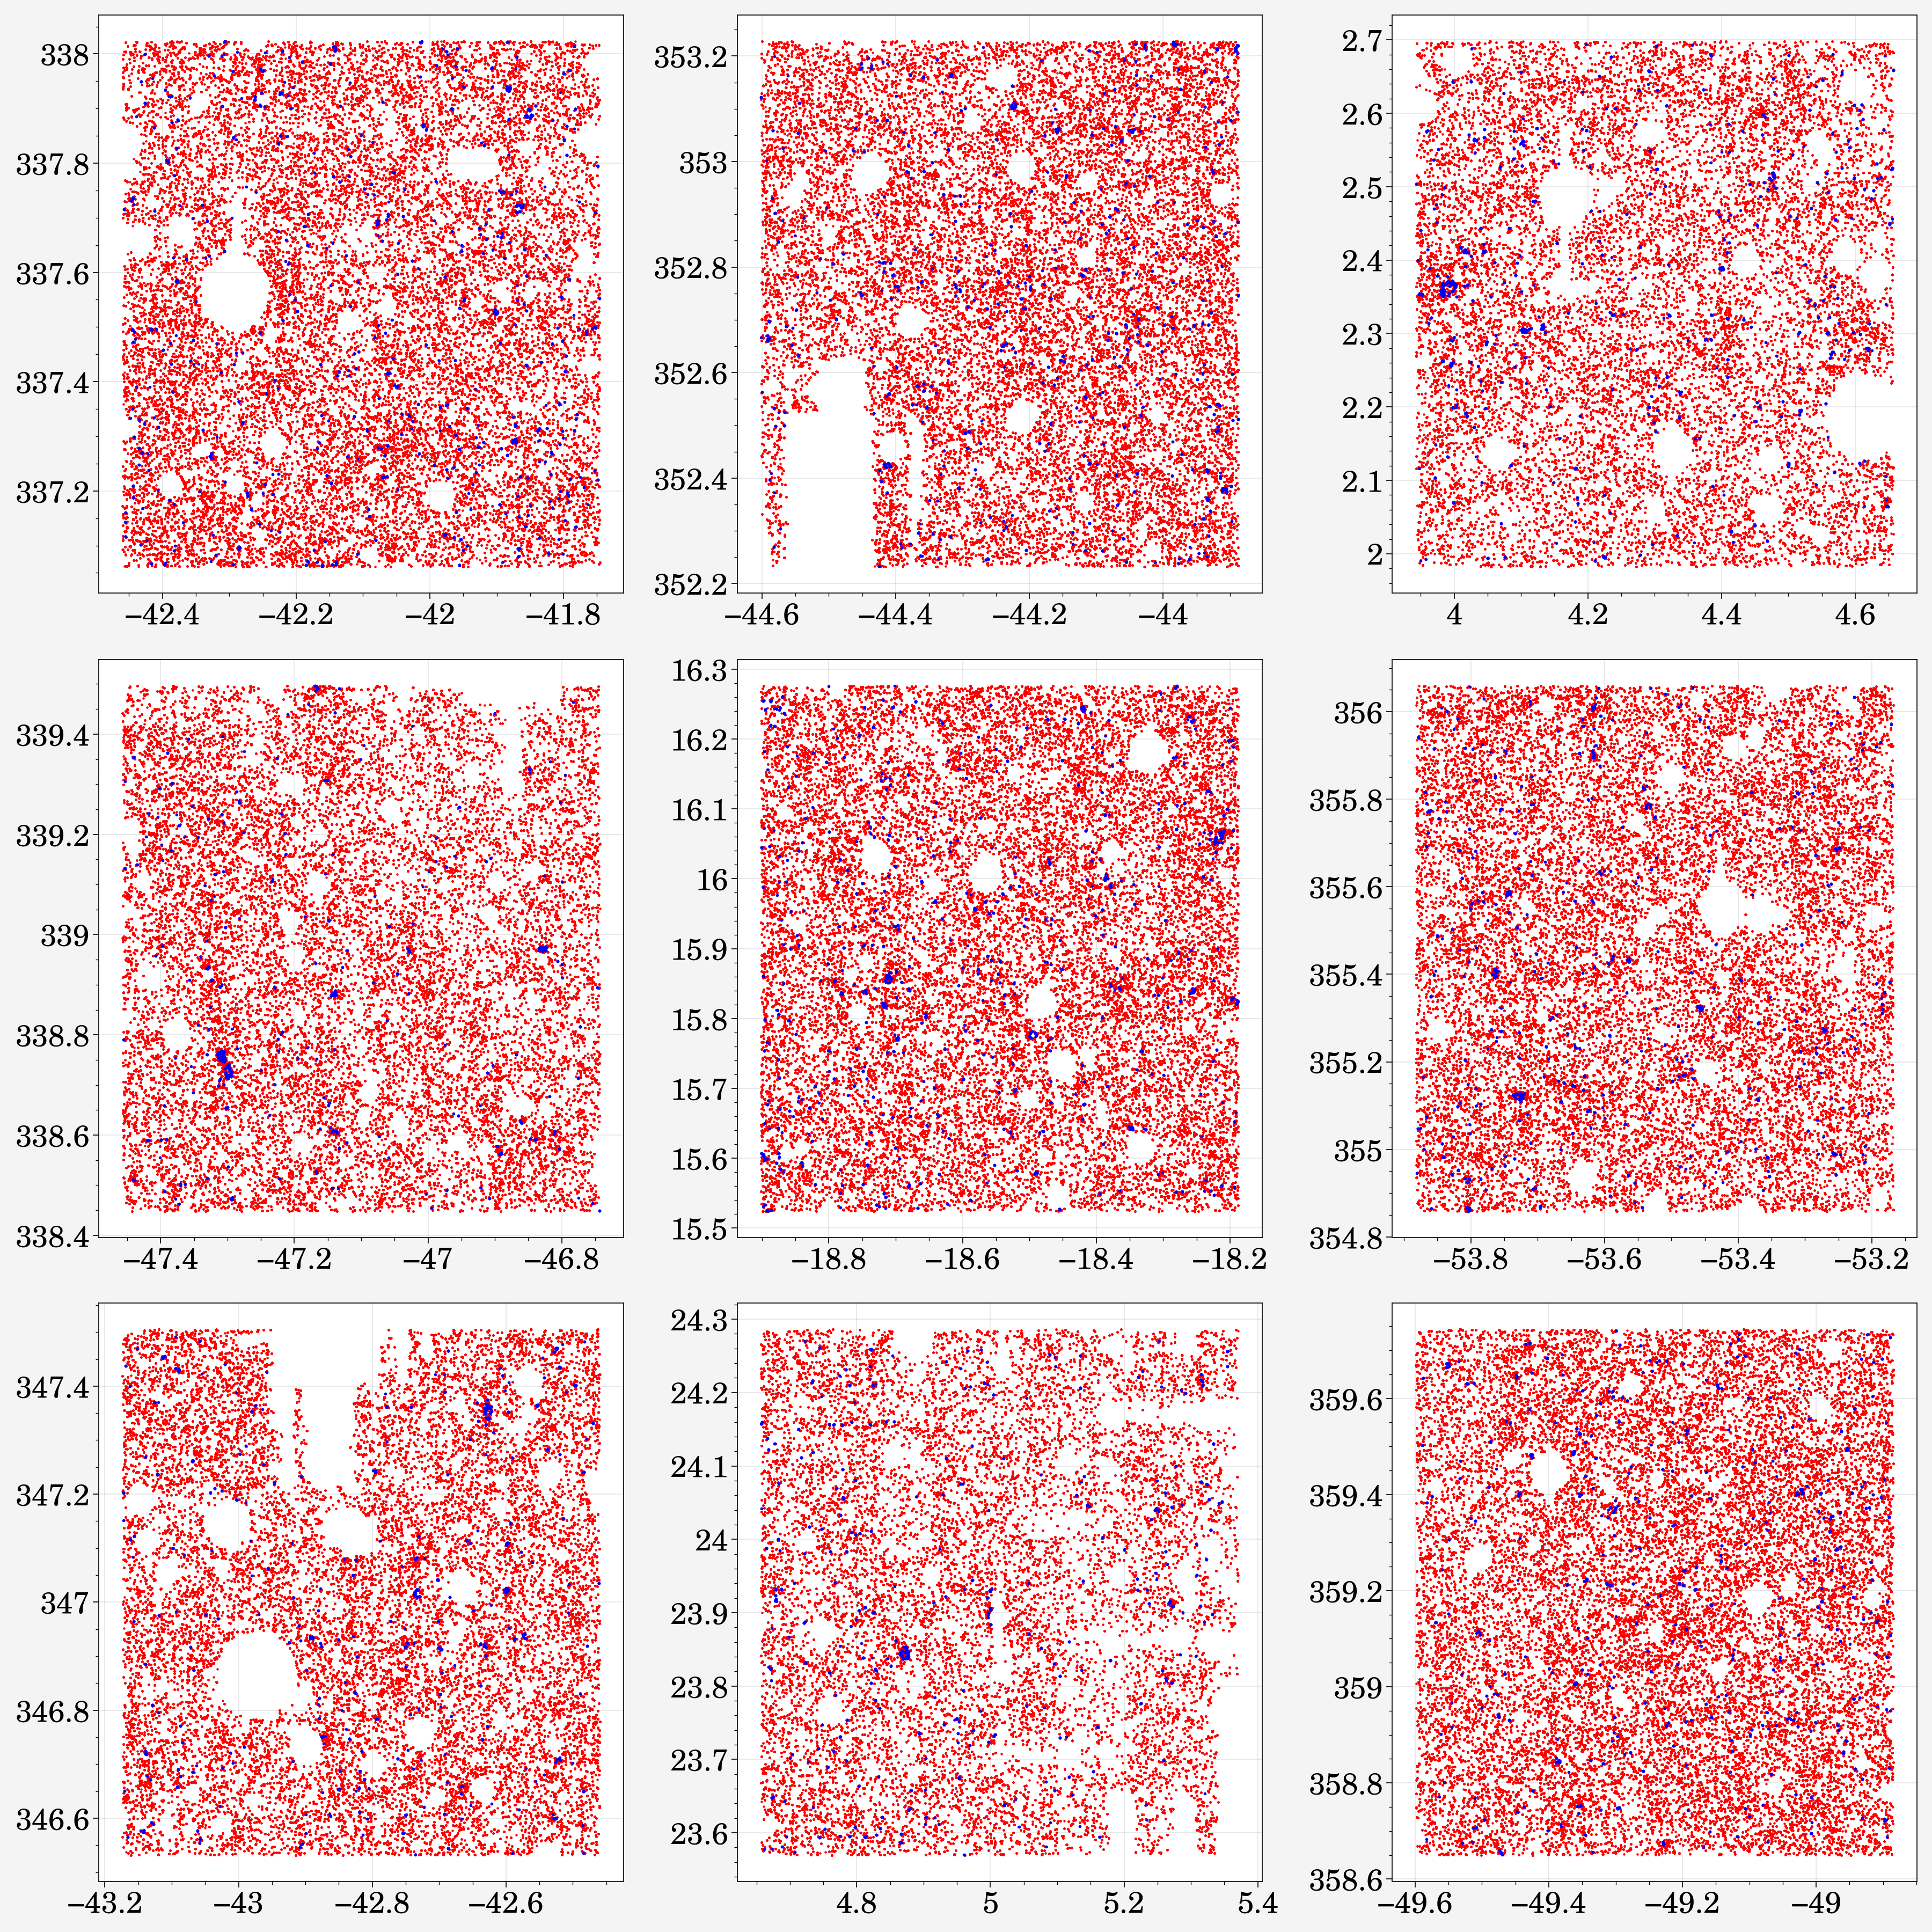

In [57]:
f = open('/global/project/projectdirs/des/myamamot/metadetect/mdet_files.txt', 'r')
fs = f.read().split('\n')[:-1]
mdet_filenames = [fname.split('/')[-1] for fname in fs]
tilenames = [d.split('_')[0] for d in mdet_filenames]

from math import log10
bins = np.logspace(log10(0.5), log10(3.0), 21)
fig = pplt.figure(figsize=(18,18), sharex=False, sharey=False)
axs = fig.subplots(nrows=3, ncols=3)
for ax,fname in zip(axs,np.random.choice(mdet_filenames, size=9)):
    d = fio.read(os.path.join('/global/project/projectdirs/des/myamamot/metadetect/cuts_v2/', fname))
    msk = ((d['mdet_T_ratio'] > bins[18]) & (d['mdet_T_ratio'] < 3.0))
    d_msk = d[msk]
    print('max T ratio', np.max(d_msk['mdet_T_ratio']), fname)
    ax.scatter(d['dec'], d['ra'], s=1, c='r')
    ax.scatter(d_msk['dec'], d_msk['ra'], s=2, c='b')
# plt.savefig('highTratio_obj_detections.pdf')
            

1172
835


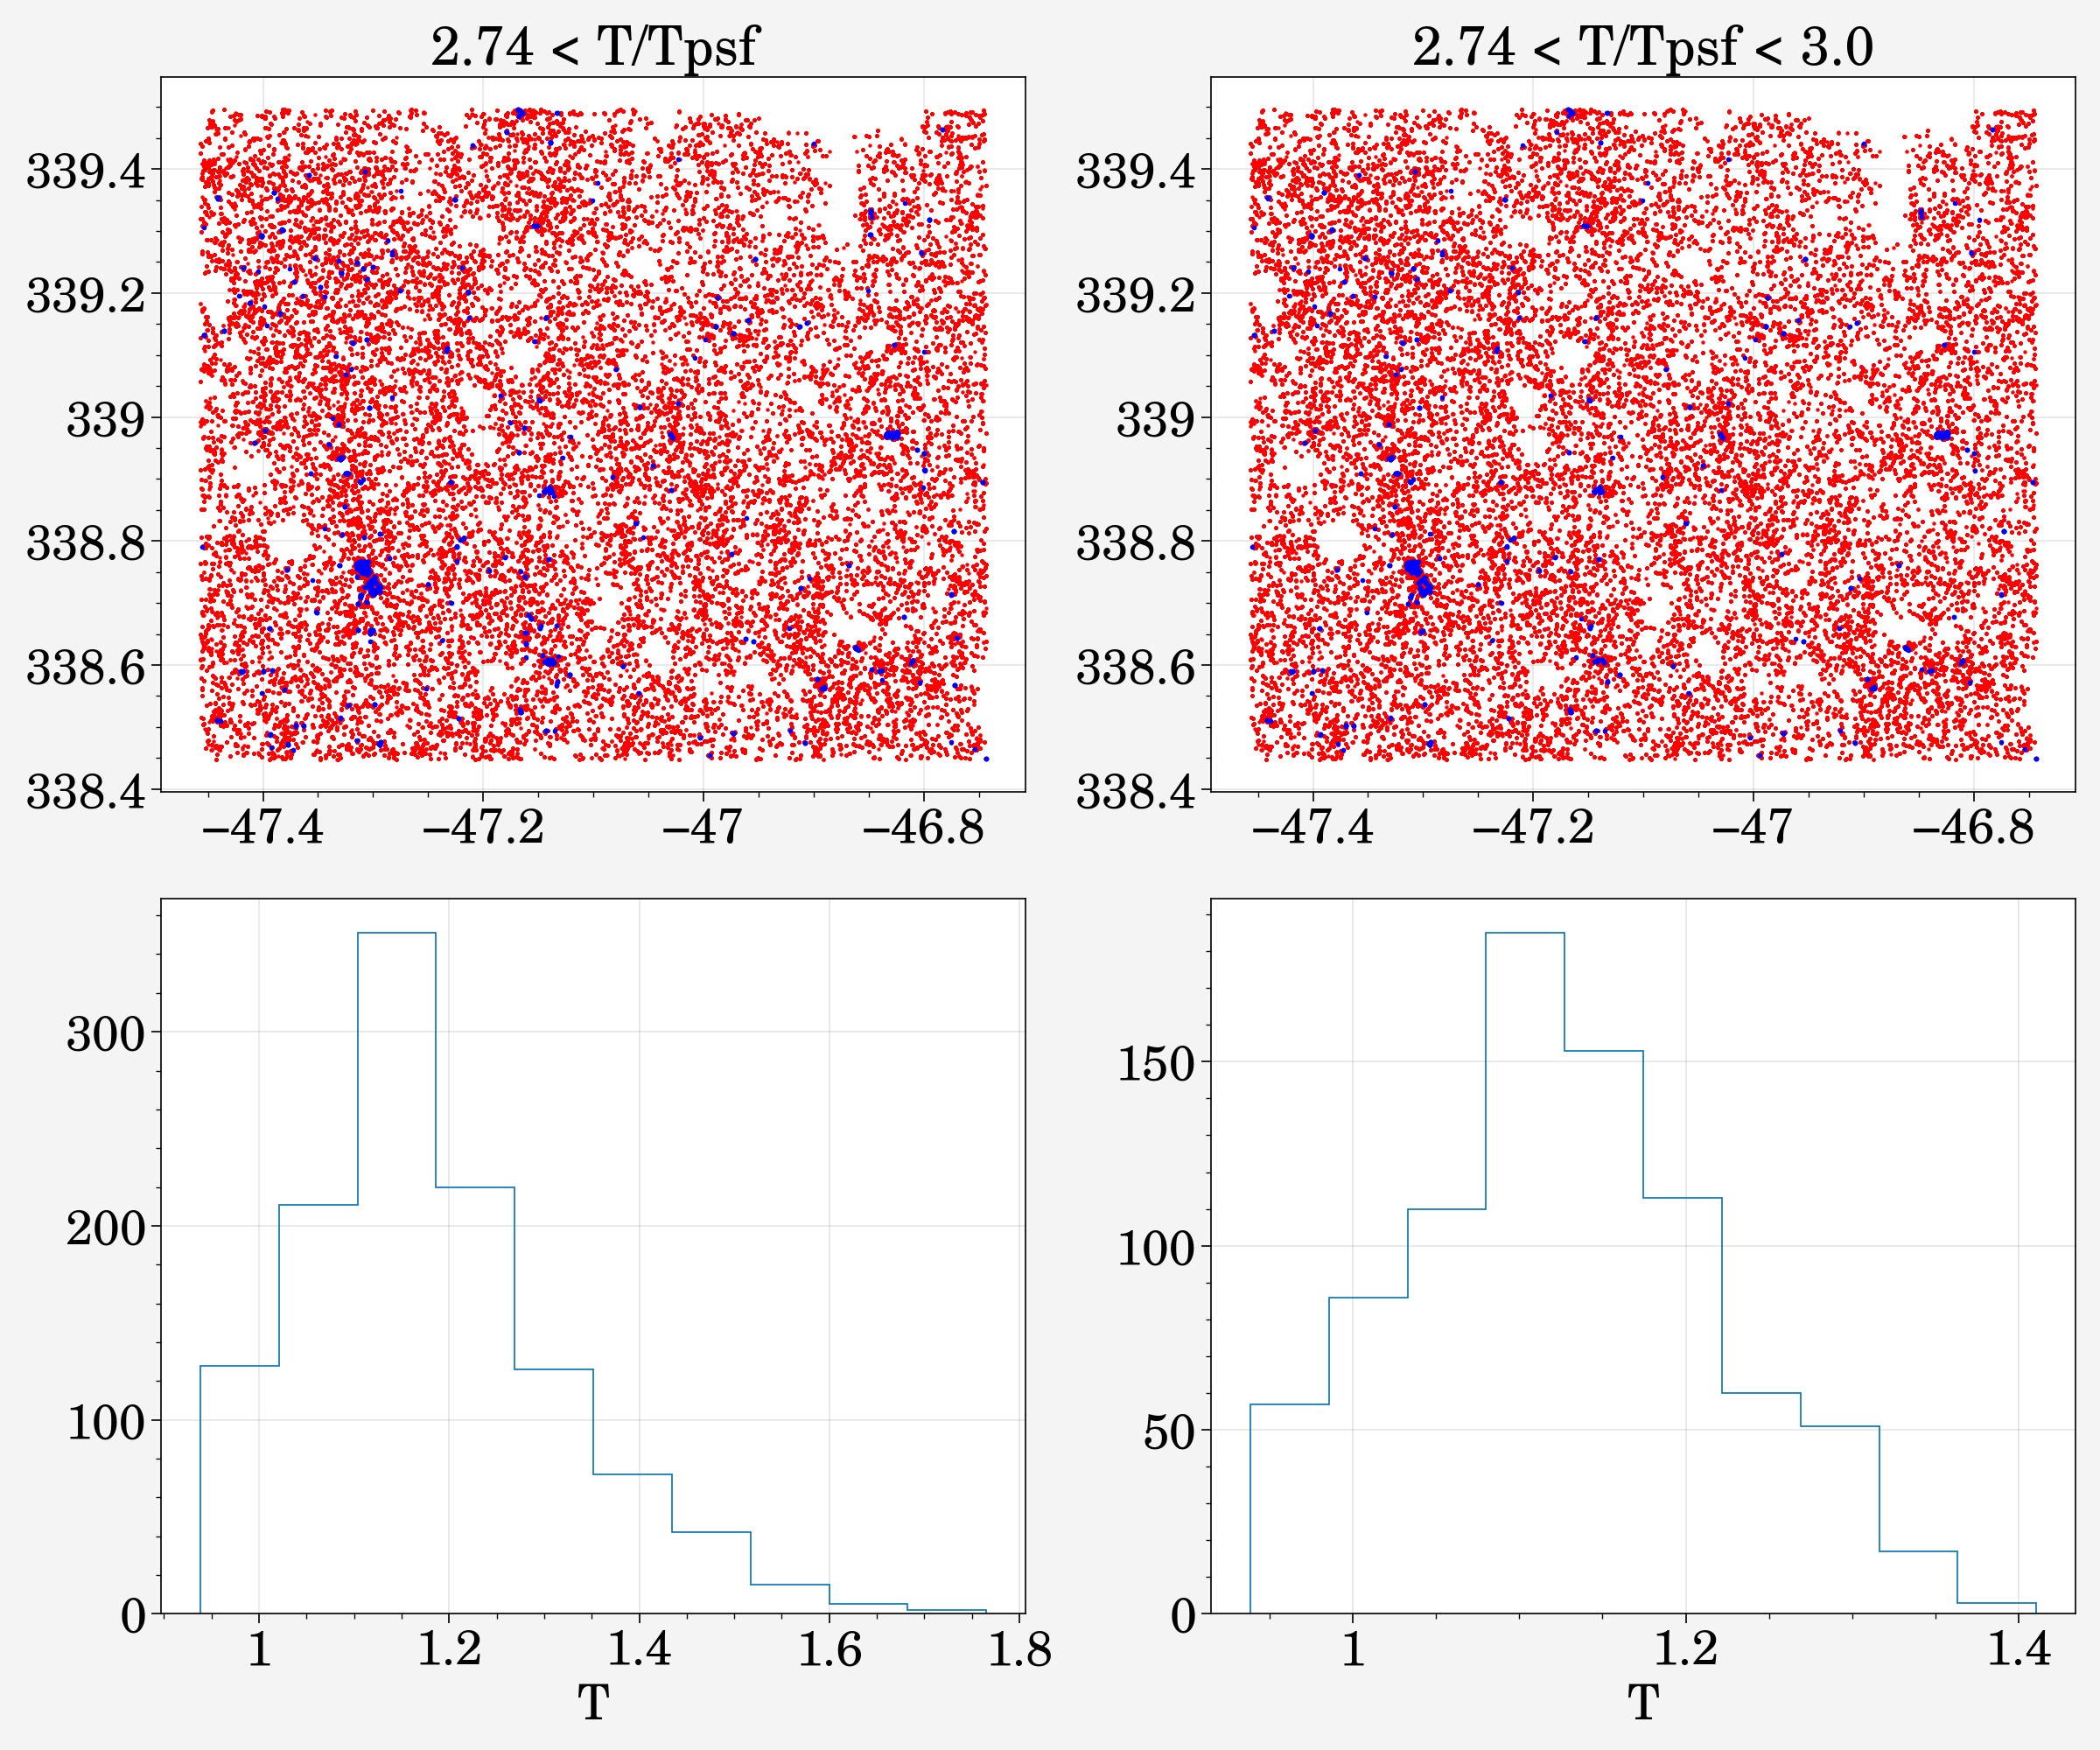

In [63]:
fig = pplt.figure(figsize=(12,10), sharex=False, sharey=False)
axs = fig.subplots(nrows=2, ncols=2)

d = fio.read(os.path.join('/global/project/projectdirs/des/myamamot/metadetect/cuts_v2/', 'DES2235-4706_metadetect-v5_mdetcat_part0000.fits'))
msk = ((d['mdet_T_ratio'] > bins[18]))
d_msk = d[msk]
print(len(d_msk))
axs[0,0].scatter(d['dec'], d['ra'], s=1, c='r')
axs[0,0].scatter(d_msk['dec'], d_msk['ra'], s=2, c='b')
axs[0,0].set_title('2.74 < T/Tpsf')

msk2 = ((d['mdet_T_ratio'] > bins[18]) & (d['mdet_T_ratio'] < 3.0))
d_msk2 = d[msk2]
print(len(d_msk2))
axs[0,1].scatter(d['dec'], d['ra'], s=1, c='r')
axs[0,1].scatter(d_msk2['dec'], d_msk2['ra'], s=2, c='b')
axs[0,1].set_title('2.74 < T/Tpsf < 3.0')

axs[1,0].hist(d_msk['mdet_T'], histtype='step')
axs[1,0].set_xlabel('T')

axs[1,1].hist(d_msk2['mdet_T'], histtype='step')
axs[1,1].set_xlabel('T')
plt.savefig('DES2235-4706_Tratio_T.pdf')

In [50]:
import pickle
with open('/global/cscratch1/sd/myamamot/metadetect/inverse_variance_weight_v2_Trcut.pickle', 'rb') as handle:
    res = pickle.load(handle)

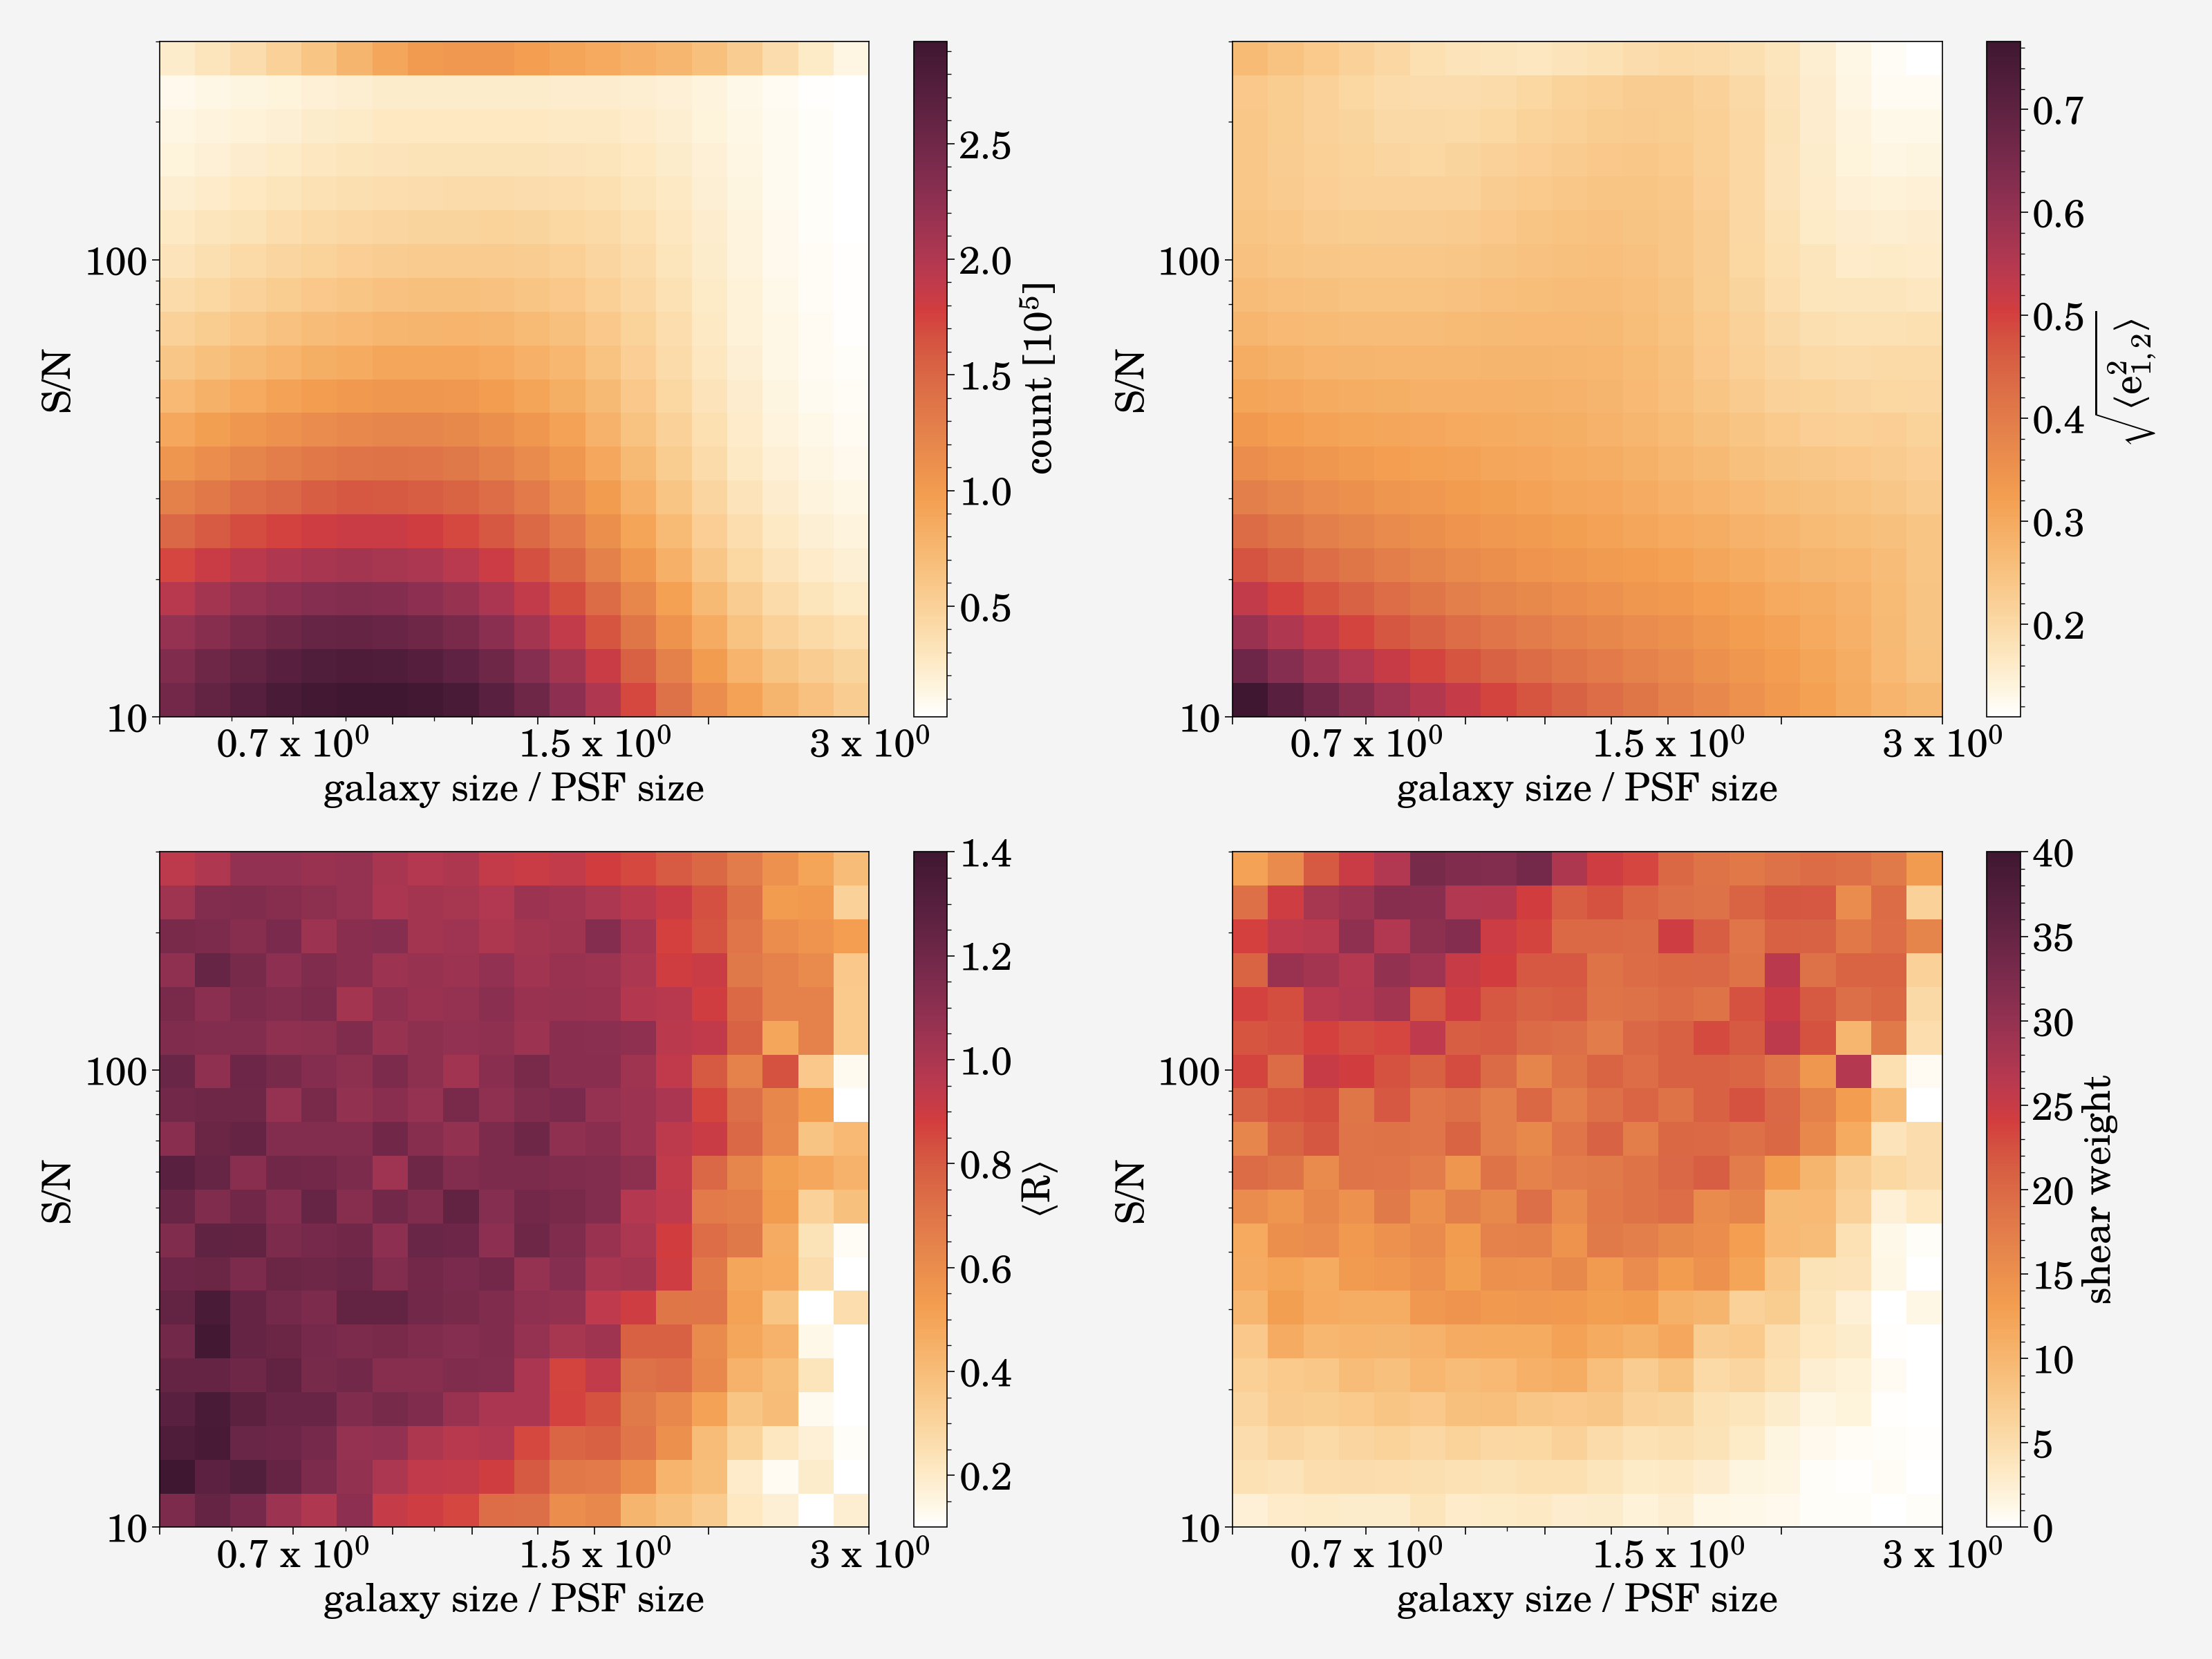

In [51]:
mpl.use('Agg')
font = {'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif')

xedges = res['xedges']
yedges = res['yedges']
count_all = res['count']
new_meanes = res['meanes']
new_response = res['response']
new_shearweight = res['weight']
    
fig=plt.figure(figsize=(16,12))
ax = plt.subplot(221)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, count_all/1.e5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
plt.xlabel("galaxy size / PSF size")
#im.colorbar(label="count")
# im.axes.get_xaxis().set_visible(True)
fig.colorbar(im, ax=ax, label=r"count [$10^5$]")
ax.set_xticks(np.array([0.5,0.7,0.9,1.1,1.3,1.5,2.,3.]))
ax.set_xticklabels(np.array(['', r'0.7 x $10^{0}$','','','',r'1.5 x $10^{0}$','',r'3 x $10^{0}$']))

# Eq 9. 
ax = plt.subplot(222)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, new_meanes)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
plt.xlabel("galaxy size / PSF size")
# im.axes.get_xaxis().set_visible(True)
fig.colorbar(im, ax=ax, label=r"$\sqrt{\langle e_{1,2}^2\rangle}$")
ax.set_xticks(np.array([0.5,0.7,0.9,1.1,1.3,1.5,2.,3.]))
ax.set_xticklabels(np.array(['', r'0.7 x $10^{0}$','','','',r'1.5 x $10^{0}$','',r'3 x $10^{0}$']))

ax = plt.subplot(223)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, new_response, vmin=0.1, vmax=1.4)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
plt.xlabel("galaxy size / PSF size")
# im.axes.get_xaxis().set_visible(True)
fig.colorbar(im, ax=ax, label=r"$\langle$R$\rangle$")
ax.set_xticks(np.array([0.5,0.7,0.9,1.1,1.3,1.5,2.,3.]))
ax.set_xticklabels(np.array(['', r'0.7 x $10^{0}$','','','',r'1.5 x $10^{0}$','',r'3 x $10^{0}$']))

ax = plt.subplot(224)
X, Y = np.meshgrid(yedges, xedges)
im = ax.pcolormesh(X, Y, new_shearweight, vmin=0, vmax=40)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("S/N")
plt.xlabel("galaxy size / PSF size")
# im.axes.get_xaxis().get_ticklabels()[3].set_visible(False)
fig.colorbar(im, ax=ax, label="shear weight")

#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plt.minorticks_off() 
ax.set_xticks(np.array([0.5,0.7,0.9,1.1,1.3,1.5,2.,3.]))
ax.set_xticklabels(np.array(['', r'0.7 x $10^{0}$','','','',r'1.5 x $10^{0}$','',r'3 x $10^{0}$']))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig('count_response_ellip_SNR_Tr_v2_Trcut.pdf', bbox_inches='tight')


# 2. Mean shear variations in focal plane coordinates

In [57]:
with open('/global/cscratch1/sd/myamamot/metadetect/shear_variations/mdet_shear_focal_plane_all.pickle', 'rb') as raw:
    ccdres_all = pickle.load(raw)

import drawDECam.drawDECam as dDECam
x0 = dDECam.CCDSECTION_X0
y0 = dDECam.CCDSECTION_Y0
name = 'e2' # 'e1'
trim = False
rotate=False
label=False
ccd_x_min = 48
ccd_x_max = 2000
ccd_y_min = 48
ccd_y_max = 4048
cell_side = 32
x_side = int(np.ceil((ccd_x_max - ccd_x_min)/cell_side))
y_side = int(np.ceil((ccd_y_max - ccd_y_min)/cell_side))

def _compute_g1_g2(ccdres, ccdnum):
    g1 = ccdres[ccdnum]["g1"] / ccdres[ccdnum]["num_g1"]
    g1p = ccdres[ccdnum]["g1p"] / ccdres[ccdnum]["num_g1p"]
    g1m = ccdres[ccdnum]["g1m"] / ccdres[ccdnum]["num_g1m"]
    R11 = (g1p - g1m) / 2 / 0.01

    g2 = ccdres[ccdnum]["g2"] / ccdres[ccdnum]["num_g2"]
    g2p = ccdres[ccdnum]["g2p"] / ccdres[ccdnum]["num_g2p"]
    g2m = ccdres[ccdnum]["g2m"] / ccdres[ccdnum]["num_g2m"]
    R22 = (g2p - g2m) / 2 / 0.01
    
    return g1/R11, g2/R22

def _compute_g1_g2_per_ccd(ccdres):
    g1 = ccdres["g1"] / ccdres["num_g1"]
    g1p = ccdres["g1p"] / ccdres["num_g1p"]
    g1m = ccdres["g1m"] / ccdres["num_g1m"]
    R11 = (g1p - g1m) / 2 / 0.01

    g2 = ccdres["g2"] / ccdres["num_g2"]
    g2p = ccdres["g2p"] / ccdres["num_g2p"]
    g2m = ccdres["g2m"] / ccdres["num_g2m"]
    R22 = (g2p - g2m) / 2 / 0.01
    
    return g1/R11, g2/R22

def compute_shear_stack_CCDs(ccdres, x_side, y_side, stack_north_south=False, per_ccd=False, block=False):
    
    shear = {}
    for direct in ['north', 'south']:
        cnames = ['g1', 'g2', 'g1p', 'g1m', 'g2p', 'g2m']
        shear_sum_all = {}
        
        if direct == 'north':
            ccd_list = np.arange(1,32)
        elif direct == 'south':
            ccd_list = np.arange(32,63)
            
        for ccdnum in list(ccd_list):
            if ccdnum not in list(ccdres):
                continue
            for cname in cnames:
                if cname not in list(shear_sum_all):
                    shear_sum_all[cname] = np.zeros((y_side, x_side))
                    shear_sum_all["num_" + cname] = np.zeros((y_side, x_side))
                if cname in list(shear_sum_all):
                    rows,cols = np.where(~np.isnan(ccdres[ccdnum][cname]))
                    np.add.at(shear_sum_all[cname], (rows, cols), ccdres[ccdnum][cname][rows, cols])
                    np.add.at(shear_sum_all["num_"+cname], (rows, cols), ccdres[ccdnum]["num_"+cname][rows, cols])
                    
        if direct == 'north':
            shear['north'] = shear_sum_all
        elif direct == 'south':
            shear['south'] = shear_sum_all

    if not stack_north_south:
        mean_north_g1, mean_north_g2  = _compute_g1_g2_per_ccd(shear['north'])
        mean_south_g1, mean_south_g2  = _compute_g1_g2_per_ccd(shear['south'])
        
        mean_north_g1 = np.rot90(mean_north_g1, 3)
        mean_north_g2 = np.rot90(mean_north_g2, 3)
        mean_south_g1 = np.rot90(mean_south_g1, 3)
        mean_south_g2 = np.rot90(mean_south_g2, 3)
        mean_g1 = [mean_north_g1, mean_south_g1]
        mean_g2 = [mean_north_g2, mean_south_g2]
        return mean_g1, mean_g2
    else:
        # Stack north and south but be careful of the directions of stacking.
        shear_stack = {}
        for cname in cnames:
            shear_stack[cname] = np.zeros((y_side, x_side))
            shear_stack["num_" + cname] = np.zeros((y_side, x_side))
            rows,cols = np.where(~np.isnan(shear['north'][cname]))
            np.add.at(shear_stack[cname], (rows, cols), shear['north'][cname][rows, cols])
            np.add.at(shear_stack["num_"+cname], (rows, cols), shear['north']["num_"+cname][rows, cols])
            
            shear_flip = np.flip(shear['south'][cname],0)
            shear_flip_num = shear['south']["num_"+cname]
            rows,cols = np.where(~np.isnan(shear_flip))
            np.add.at(shear_stack[cname], (rows, cols), shear_flip[rows, cols])
            np.add.at(shear_stack["num_"+cname], (rows, cols), shear_flip_num[rows, cols])
        
        if block:
            for cname in list(shear_stack):
                shear_stack[cname] = shear_stack[cname][2:-2, 2:-2]
            return shear_stack
        else:
            g1, g2  = _compute_g1_g2_per_ccd(shear_stack)
            mean_g1 = np.rot90(g1, 3)
            mean_g2 = np.rot90(g2, 3)
            return mean_g1, mean_g2

## 3-1. Lay out 62 CCDs (Use ALL)

<ipython-input-57-3a23f939e5a8>:20: RuntimeWarning: invalid value encountered in true_divide
  g1 = ccdres[ccdnum]["g1"] / ccdres[ccdnum]["num_g1"]
<ipython-input-57-3a23f939e5a8>:21: RuntimeWarning: invalid value encountered in true_divide
  g1p = ccdres[ccdnum]["g1p"] / ccdres[ccdnum]["num_g1p"]
<ipython-input-57-3a23f939e5a8>:22: RuntimeWarning: invalid value encountered in true_divide
  g1m = ccdres[ccdnum]["g1m"] / ccdres[ccdnum]["num_g1m"]
<ipython-input-57-3a23f939e5a8>:25: RuntimeWarning: invalid value encountered in true_divide
  g2 = ccdres[ccdnum]["g2"] / ccdres[ccdnum]["num_g2"]
<ipython-input-57-3a23f939e5a8>:26: RuntimeWarning: invalid value encountered in true_divide
  g2p = ccdres[ccdnum]["g2p"] / ccdres[ccdnum]["num_g2p"]
<ipython-input-57-3a23f939e5a8>:27: RuntimeWarning: invalid value encountered in true_divide
  g2m = ccdres[ccdnum]["g2m"] / ccdres[ccdnum]["num_g2m"]


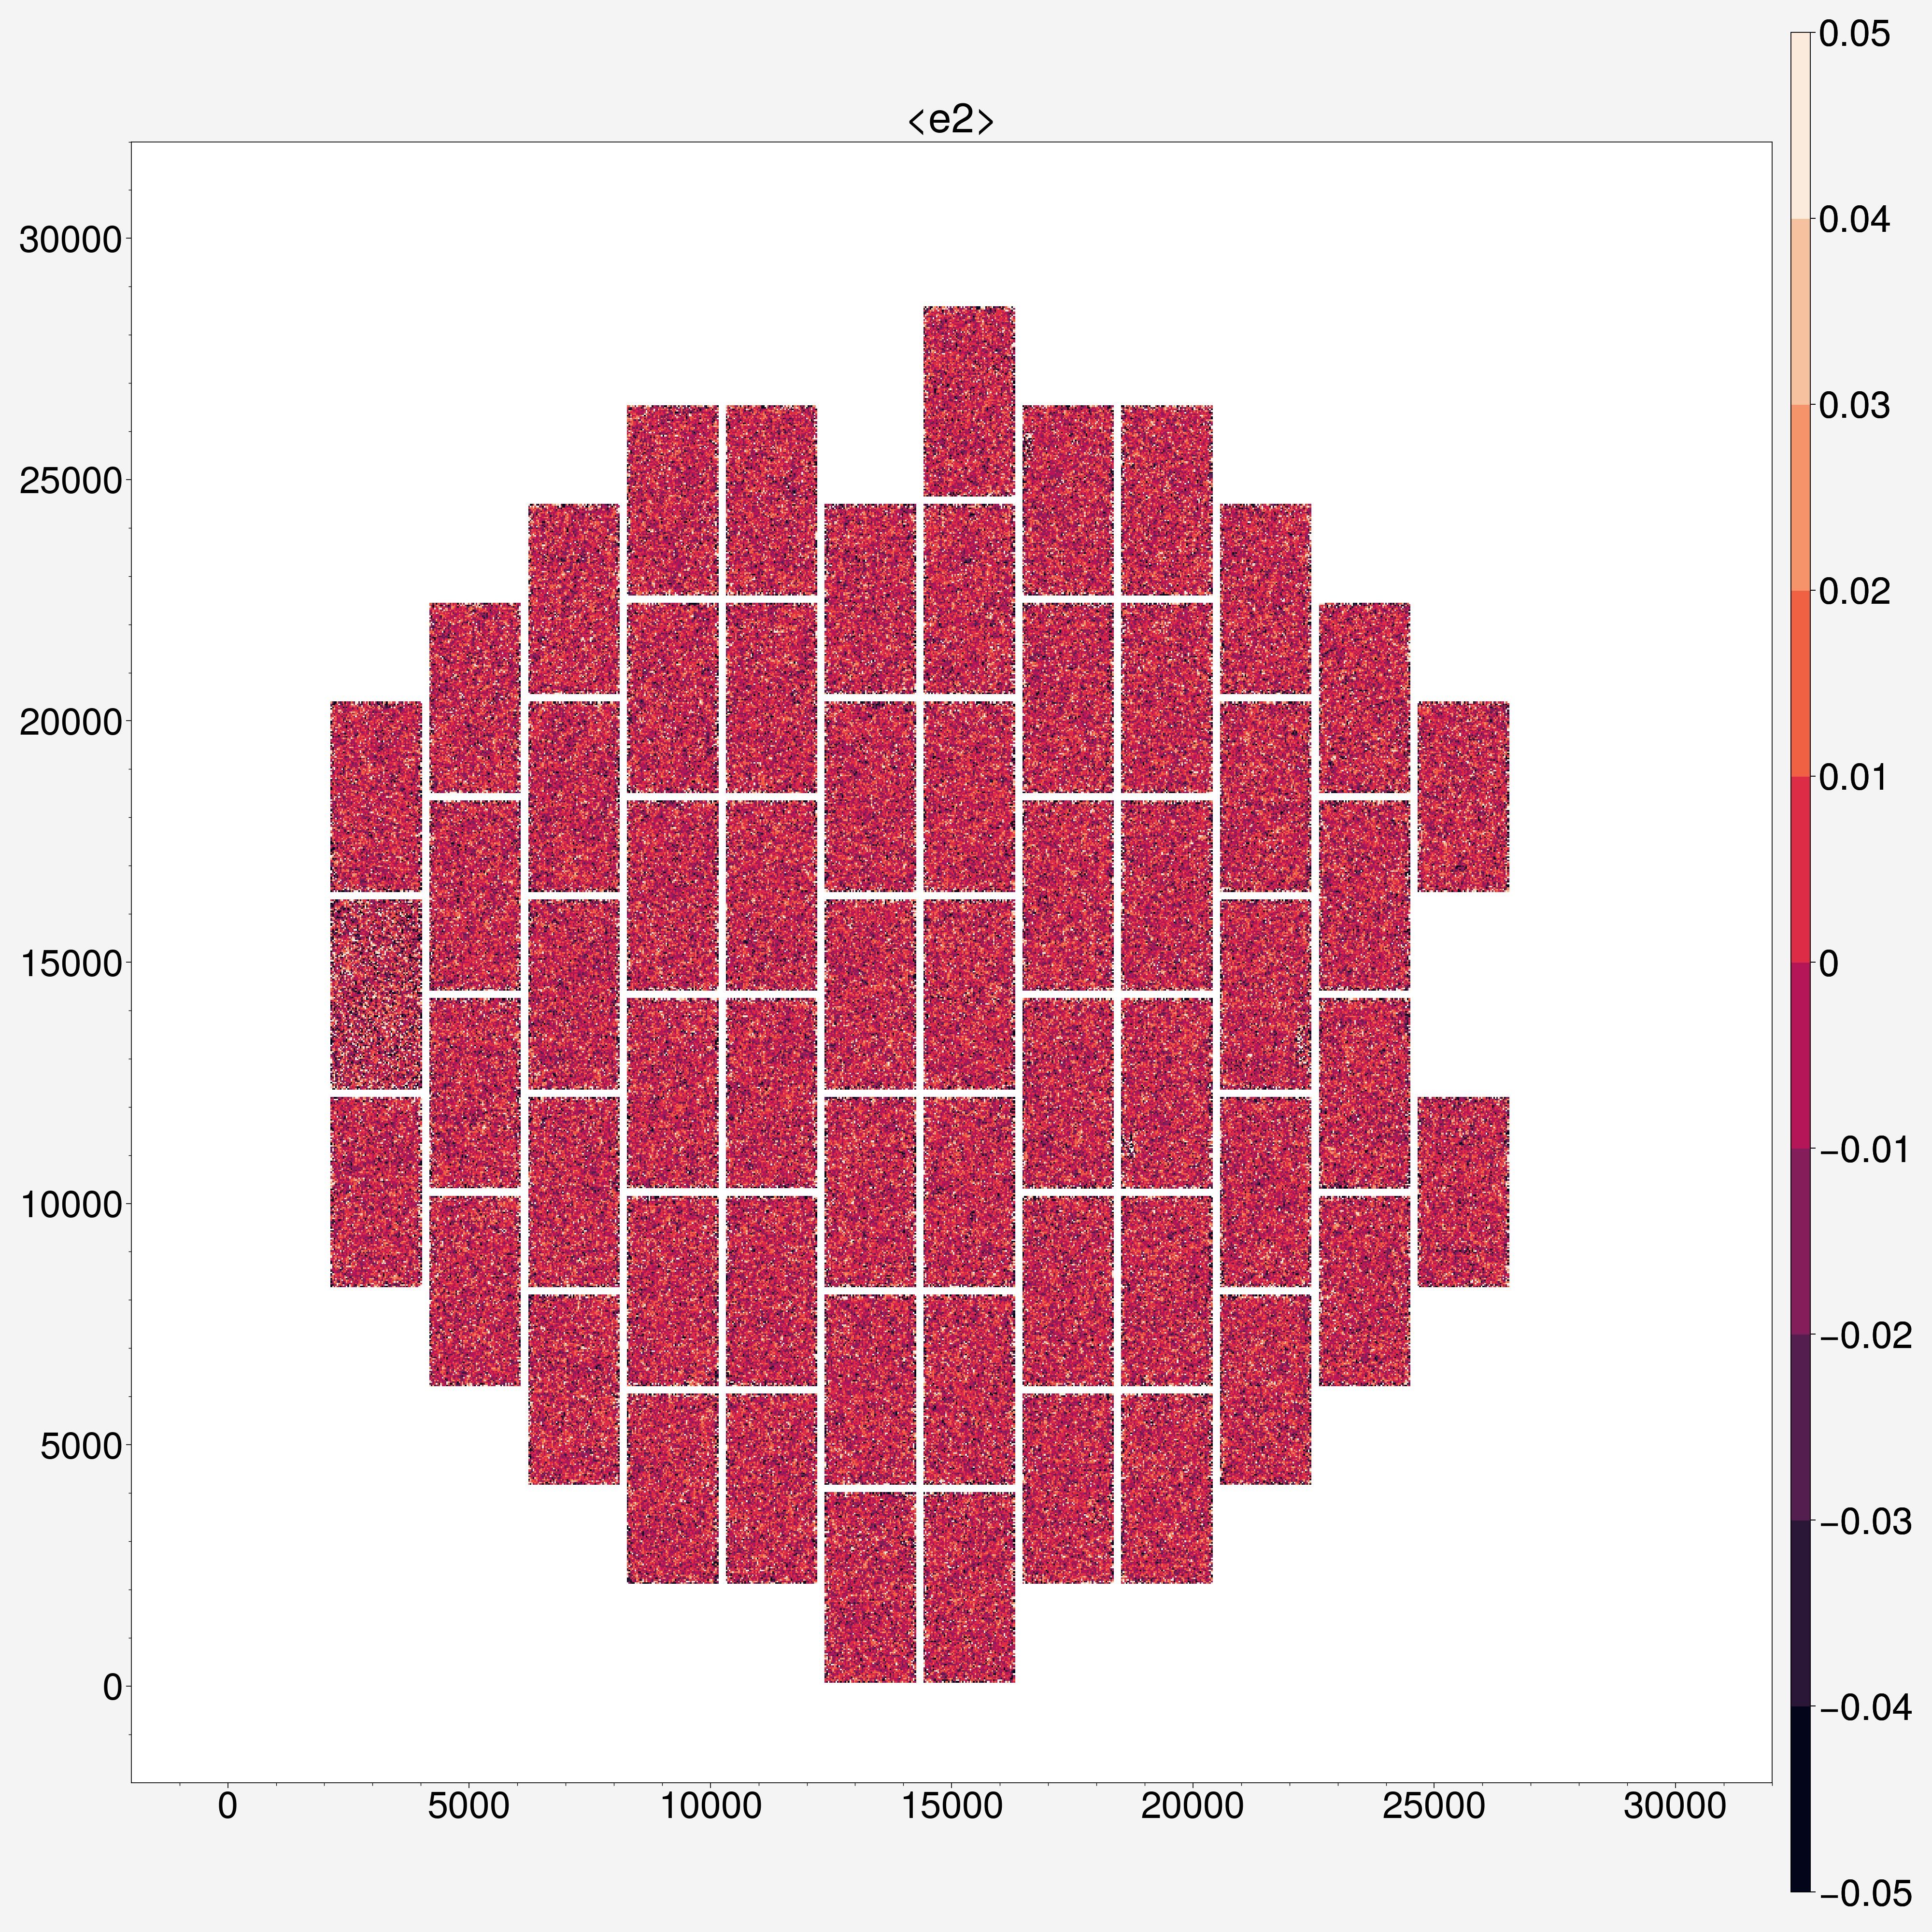

In [58]:

# Draw DECam CCDs using Plot function (Unrotated)
def rotate_xy(x, y, theta, x0=0, y0=0, units='degrees'):
    """
    Rotates (x,y) by angle theta and (x0,y0) translation
    """
    if units == 'degrees':
        d2r = math.pi / 180.  # degrees to radians shorthand
        theta = d2r * theta
    x_new = (x - x0) * math.cos(theta) - (y - y0) * math.sin(theta)
    y_new = (x - x0) * math.sin(theta) + (y - y0) * math.cos(theta)
    return x_new, y_new

"""
Draws DECam CCDs shapes using matplotlib Plot function on the current plot
"""
mpl.rcParams.update({'font.size': 28})
fig = pplt.figure(figsize=(20,20))
ax = fig.subplots()
if trim:
    TRIM_CCDSECTIONS = dDECam.CCDSECTIONS.copy()
    borderpix = 104  # 208/2. as 208 is the space between chips in pixels
    for _k, _v in list(TRIM_CCDSECTIONS.items()):
        (_x1, _x2, _y1, _y2) = _v
        _x1 = _x1 + borderpix
        _x2 = _x2 - borderpix
        _y1 = _y1 + borderpix
        _y2 = _y2 - borderpix
        TRIM_CCDSECTIONS[_k] = [_x1, _x2, _y1, _y2]
    SECTIONS = TRIM_CCDSECTIONS
else:
    SECTIONS = dDECam.CCDSECTIONS

for k, v in list(SECTIONS.items()):
    (x1, x2, y1, y2) = v
    # if rotate:
    #     x1, y1 = rotate_xy(x1, y1, theta=-90, x0=x0, y0=y0)
    #     x2, y2 = rotate_xy(x2, y2, theta=-90, x0=x0, y0=y0)
    # else:
    #     x1, y1 = rotate_xy(x1, y1, theta=0, x0=x0, y0=y0)
    #     x2, y2 = rotate_xy(x2, y2, theta=0, x0=x0, y0=y0)
    if k in list(ccdres_all):
        g1, g2 = _compute_g1_g2(ccdres_all, k)
    else:
        continue
    # Into numpy arrays
    x = np.array([x1, x2, x2, x1, x1])
    y = np.array([y1, y1, y2, y2, y1])

    cmap = plt.get_cmap('rocket')
    X, Y = np.meshgrid(np.linspace(x1+48, x2-48, x_side+1), np.linspace(y1+48, y2-48, y_side+1))
    if name == 'e1':
        mesh = ax.pcolormesh(X, Y, g1, vmin=-0.05, vmax=0.05, snap=True, cmap=cmap)
    elif name == 'e2':
        mesh = ax.pcolormesh(X, Y, g2, vmin=-0.05, vmax=0.05, snap=True, cmap=cmap)

ax.set_xlim(-2000,32000)
ax.set_ylim(-2000,32000)
ax.set_aspect(1)
ax.set_title('<'+name+'>')
# plt.tight_layout()
plt.colorbar(mesh, ax=ax)
plt.savefig('mdet_shear_variations_focal_plane_'+name+'_v2.pdf', bbox_inches='tight')
plt.show()

## 3-2. Stack 1-31 CCDs (North) and 32-62 CCDs (South) (Use ALL)

<ipython-input-57-3a23f939e5a8>:33: RuntimeWarning: invalid value encountered in true_divide
  g1 = ccdres["g1"] / ccdres["num_g1"]
<ipython-input-57-3a23f939e5a8>:34: RuntimeWarning: invalid value encountered in true_divide
  g1p = ccdres["g1p"] / ccdres["num_g1p"]
<ipython-input-57-3a23f939e5a8>:35: RuntimeWarning: invalid value encountered in true_divide
  g1m = ccdres["g1m"] / ccdres["num_g1m"]
<ipython-input-57-3a23f939e5a8>:38: RuntimeWarning: invalid value encountered in true_divide
  g2 = ccdres["g2"] / ccdres["num_g2"]
<ipython-input-57-3a23f939e5a8>:39: RuntimeWarning: invalid value encountered in true_divide
  g2p = ccdres["g2p"] / ccdres["num_g2p"]
<ipython-input-57-3a23f939e5a8>:40: RuntimeWarning: invalid value encountered in true_divide
  g2m = ccdres["g2m"] / ccdres["num_g2m"]
<ipython-input-59-0a99bac27d49>:55: ProplotWarning: fig.subplots_adjust() has no effect on proplot figures. To set the left, right, bottom, top, wspace, or hspace gridspec values, pass them as key

<Figure size 400x400 with 0 Axes>

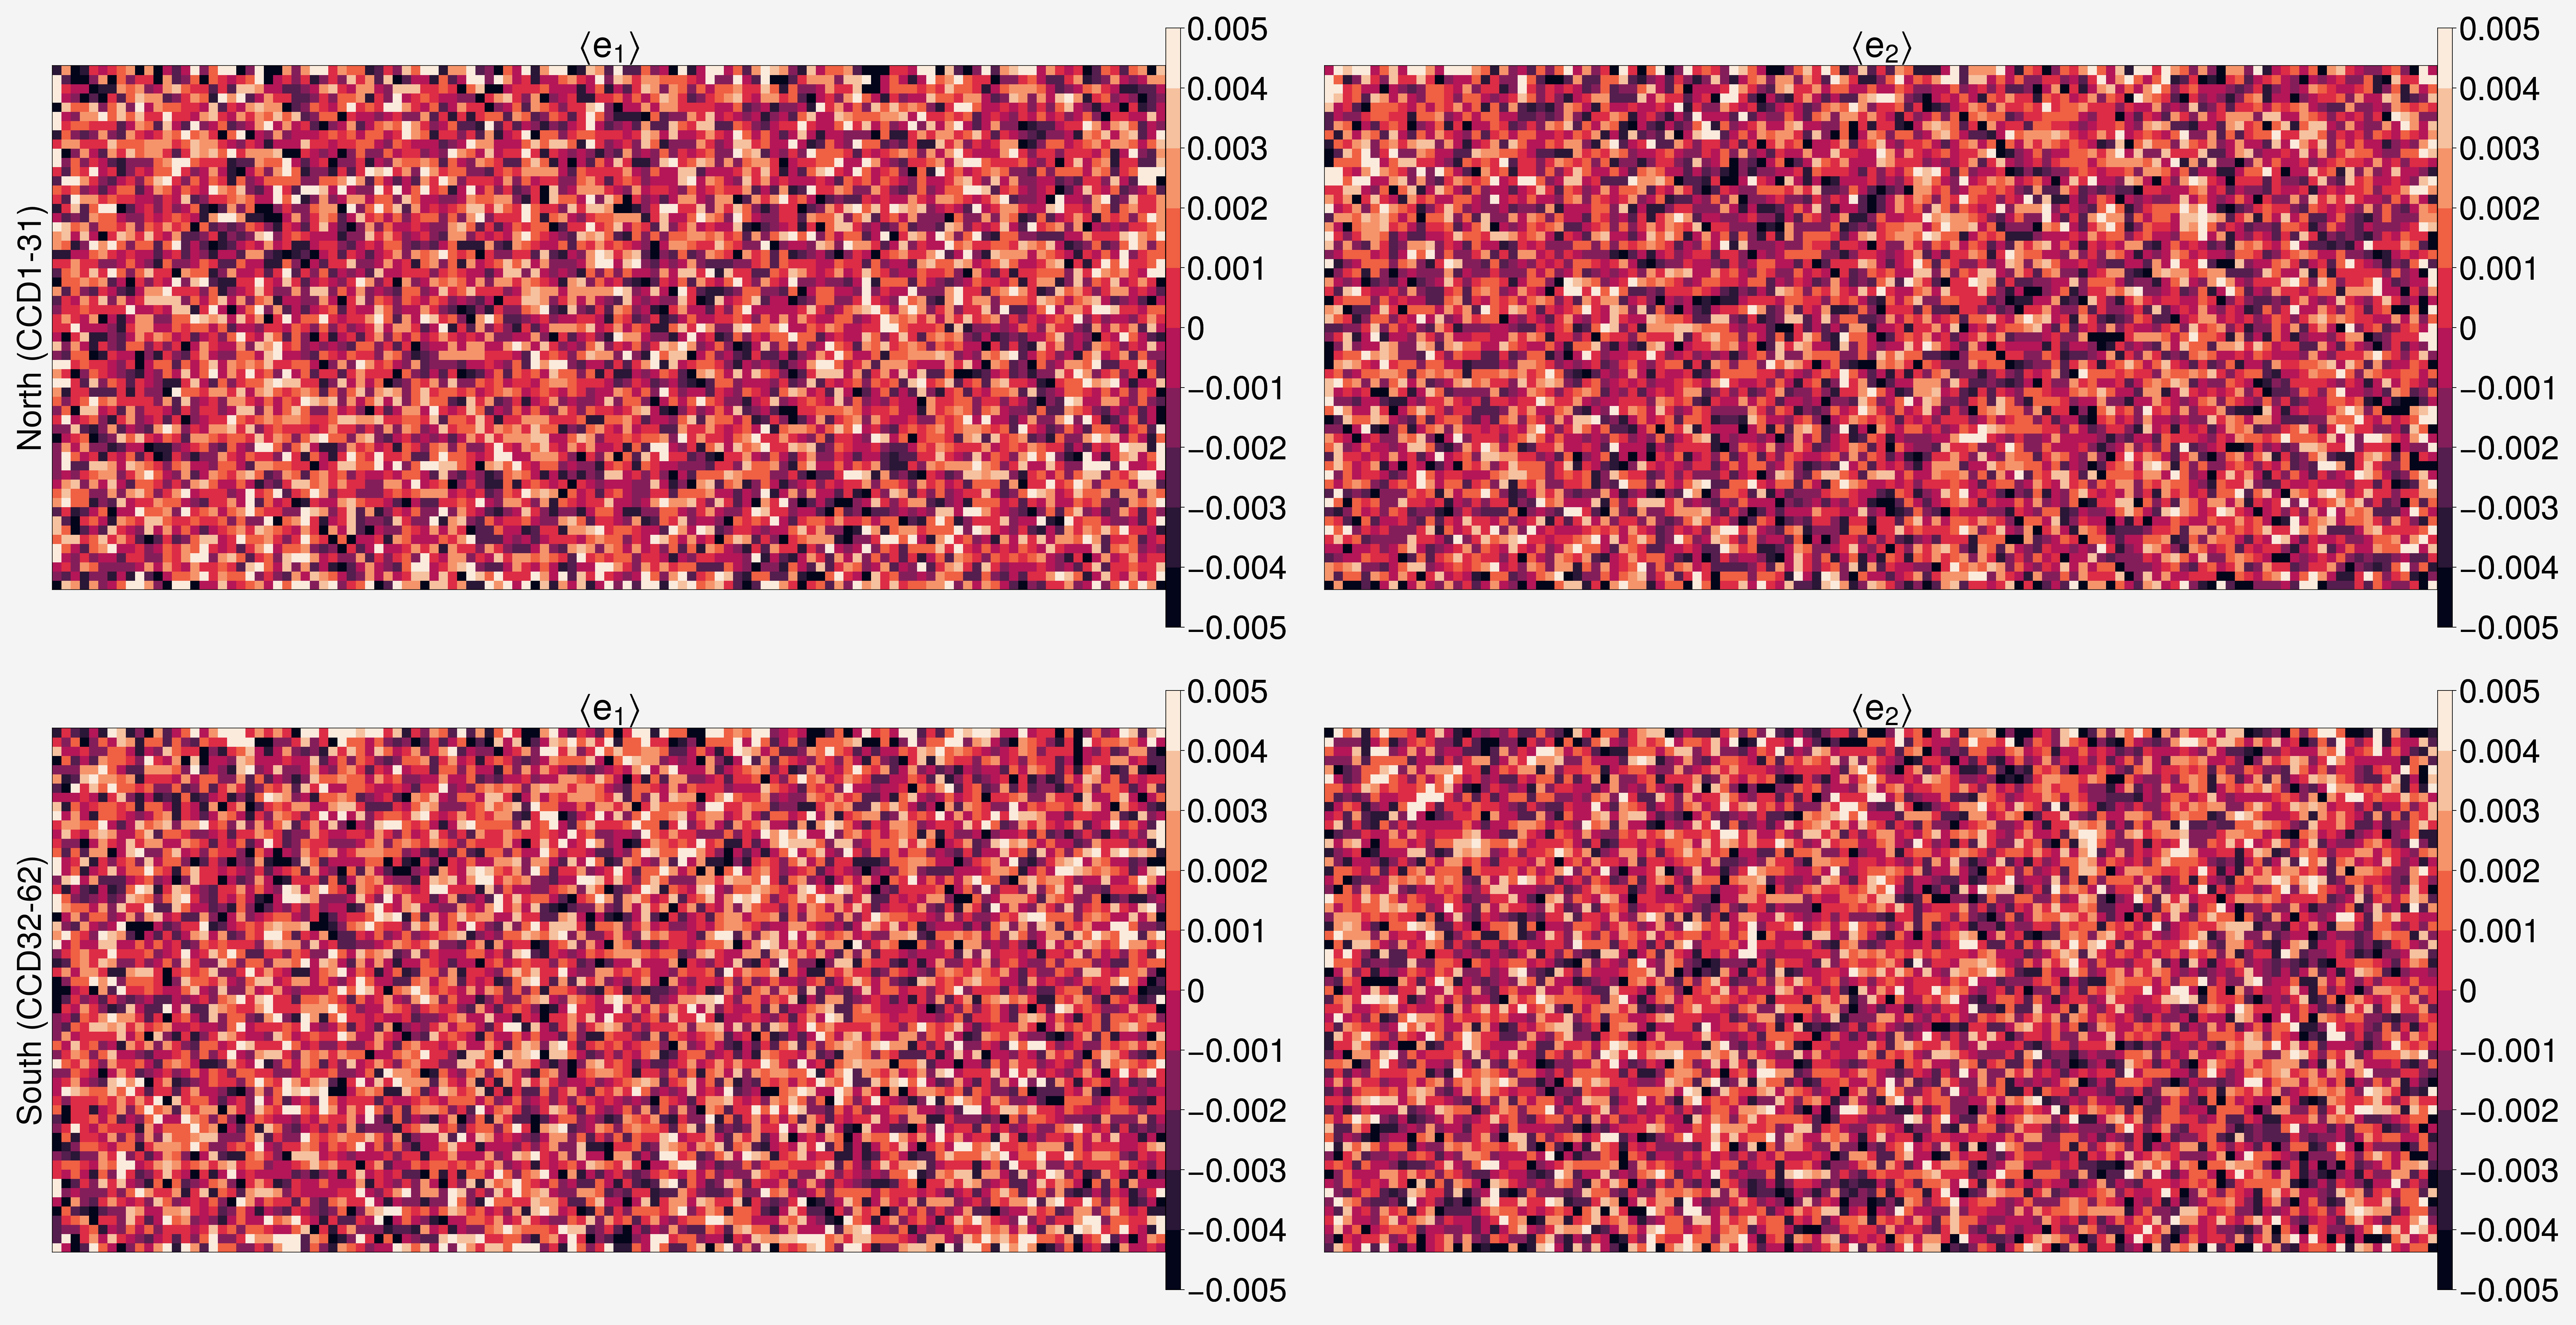

In [59]:

mean_g1, mean_g2 = compute_shear_stack_CCDs(ccdres_all, x_side, y_side, stack_north_south=False)
for i in range(2):
    mean_g1[i] = mean_g1[i][2:-2, 2:-2]
    mean_g2[i] = mean_g2[i][2:-2, 2:-2]

plt.clf()
mpl.rcParams.update({'font.size': 32})
fig = pplt.figure(figsize=(35,18), sharex=False, sharey=False)
ax1 = fig.subplots(nrows=2, ncols=2)

cmap = plt.get_cmap('rocket')
# cmap.set_bad(color='k', alpha=1.)
piece_side = 32
X, Y = np.meshgrid(np.linspace(1, 3873, (3872//piece_side)+1), np.linspace(1, 1825, (1824//piece_side)+1))

mean = np.nanmean(mean_g1[0])
sig = np.nanstd(mean_g1[0]) / np.sqrt(mean_g1[0].size)
mesh = ax1[0,0].pcolormesh(X,Y,mean_g1[0], vmin=-0.005, vmax=0.005, cmap=cmap)
ax1[0,0].set_aspect(1)
ax1[0,0].set_title(r'$\langle e_{1} \rangle$')
ax1[0,0].set_xticks([])
ax1[0,0].set_yticks([])
ax1[0,0].set_ylabel('North (CCD1-31)')
plt.colorbar(mesh, ax=ax1[0,0], pad=0.01)

mean = np.nanmean(mean_g2[0])
sig = np.nanstd(mean_g2[0]) / np.sqrt(mean_g2[0].size)
mesh = ax1[0,1].pcolormesh(X,Y,mean_g2[0], vmin=-0.005, vmax=0.005, cmap=cmap)
ax1[0,1].set_aspect(1)
ax1[0,1].set_title(r'$\langle e_{2} \rangle$')
ax1[0,1].set_xticks([])
ax1[0,1].set_yticks([])
plt.colorbar(mesh, ax=ax1[0,1], pad=0.01)

mean = np.nanmean(mean_g1[1])
sig = np.nanstd(mean_g1[1]) / np.sqrt(mean_g1[1].size)
mesh = ax1[1,0].pcolormesh(X,Y,mean_g1[1], vmin=-0.005, vmax=0.005, cmap=cmap)
ax1[1,0].set_aspect(1)
ax1[1,0].set_title(r'$\langle e_{1} \rangle$')
ax1[1,0].set_xticks([])
ax1[1,0].set_yticks([])
ax1[1,0].set_ylabel('South (CCD32-62)')
plt.colorbar(mesh, ax=ax1[1,0], pad=0.01)


mean = np.nanmean(mean_g2[1][mean_g2[1] > -10])
sig = np.nanstd(mean_g2[1][mean_g2[1] > -10]) / np.sqrt(mean_g2[1][mean_g2[1] > -10].size)
mesh = ax1[1,1].pcolormesh(X,Y,mean_g2[1], vmin=-0.005, vmax=0.005, cmap=cmap)
ax1[1,1].set_aspect(1)
ax1[1,1].set_title(r'$\langle e_{2} \rangle$')
ax1[1,1].set_xticks([])
ax1[1,1].set_yticks([])
plt.colorbar(mesh, ax=ax1[1,1], pad=0.01)

plt.subplots_adjust(hspace=0.3,wspace=0.1)
plt.savefig('mdet_shear_variations_focal_plane_stacked_north_south_v2.pdf', bbox_inches='tight')
plt.show()

[-0.05619195 -0.08754518 -0.070719   -0.15281066 -0.0550333  -0.09523953
 -0.05880307 -0.06832115 -0.08698578 -0.05807784]
[-0.0523578  -0.08957798 -0.07520355 -0.08377028 -0.12426661 -0.15754813
 -0.11452183 -0.12957367]
[-0.64218646 -0.35903875]
[-0.06393486 -0.05561471 -0.06754332 -0.08968224]


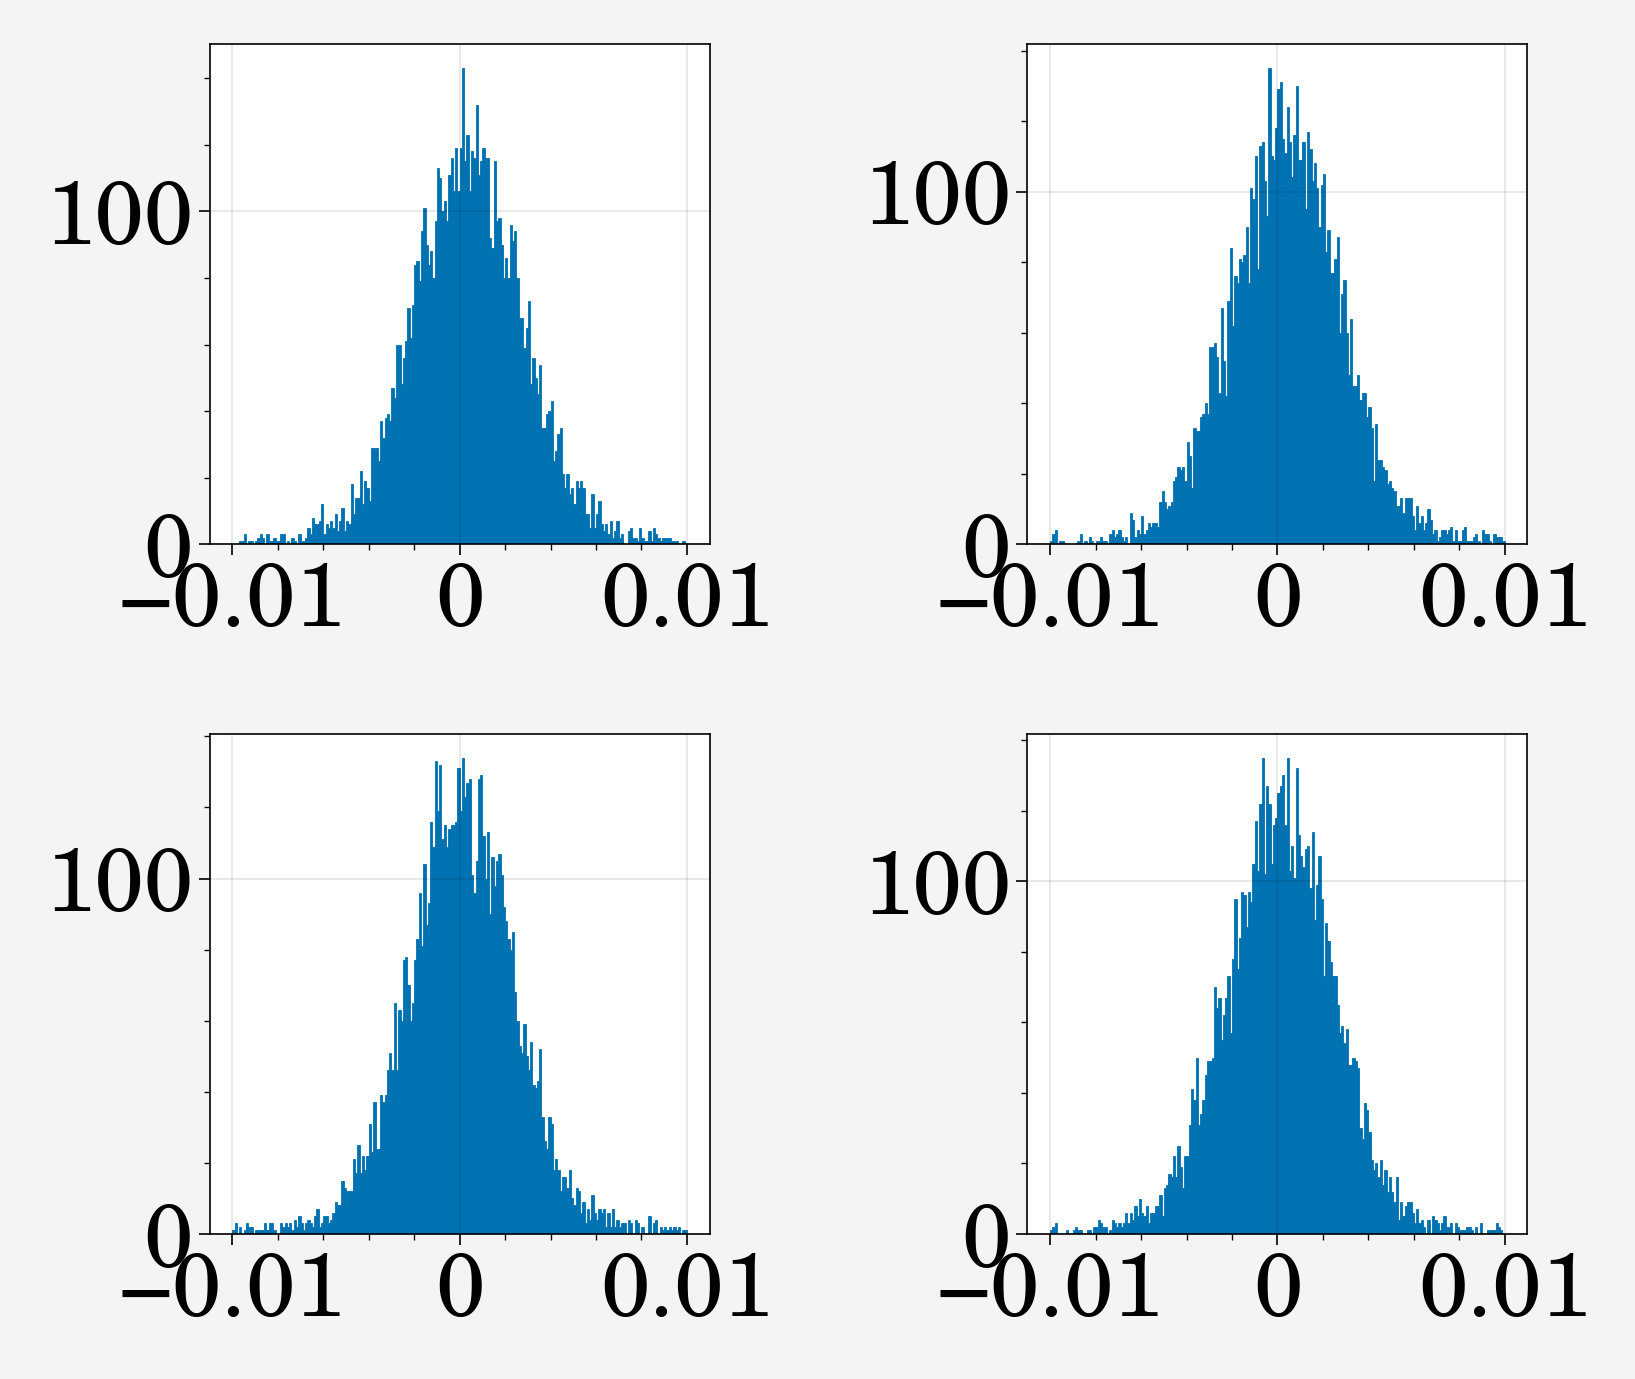

In [76]:
fig = pplt.figure(sharex=False, sharey=False)
ax = fig.subplots(nrows=2,ncols=2)
for i,g in enumerate([mean_g1, mean_g2]):
    for j in range(2):
        ax[i,j].hist(g[j].flatten(), bins=200, range=(-0.01, 0.01))
        print(g[j][g[j] < -0.05])
plt.show()

## 3-3. Stack all 62 CCDs together (Use per-CCD and ALL files)

<ipython-input-57-3a23f939e5a8>:33: RuntimeWarning: invalid value encountered in true_divide
  g1 = ccdres["g1"] / ccdres["num_g1"]
<ipython-input-57-3a23f939e5a8>:34: RuntimeWarning: invalid value encountered in true_divide
  g1p = ccdres["g1p"] / ccdres["num_g1p"]
<ipython-input-57-3a23f939e5a8>:35: RuntimeWarning: invalid value encountered in true_divide
  g1m = ccdres["g1m"] / ccdres["num_g1m"]
<ipython-input-57-3a23f939e5a8>:38: RuntimeWarning: invalid value encountered in true_divide
  g2 = ccdres["g2"] / ccdres["num_g2"]
<ipython-input-57-3a23f939e5a8>:39: RuntimeWarning: invalid value encountered in true_divide
  g2p = ccdres["g2p"] / ccdres["num_g2p"]
<ipython-input-57-3a23f939e5a8>:40: RuntimeWarning: invalid value encountered in true_divide
  g2m = ccdres["g2m"] / ccdres["num_g2m"]


[] []


<ipython-input-60-907b5997ddd3>:58: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


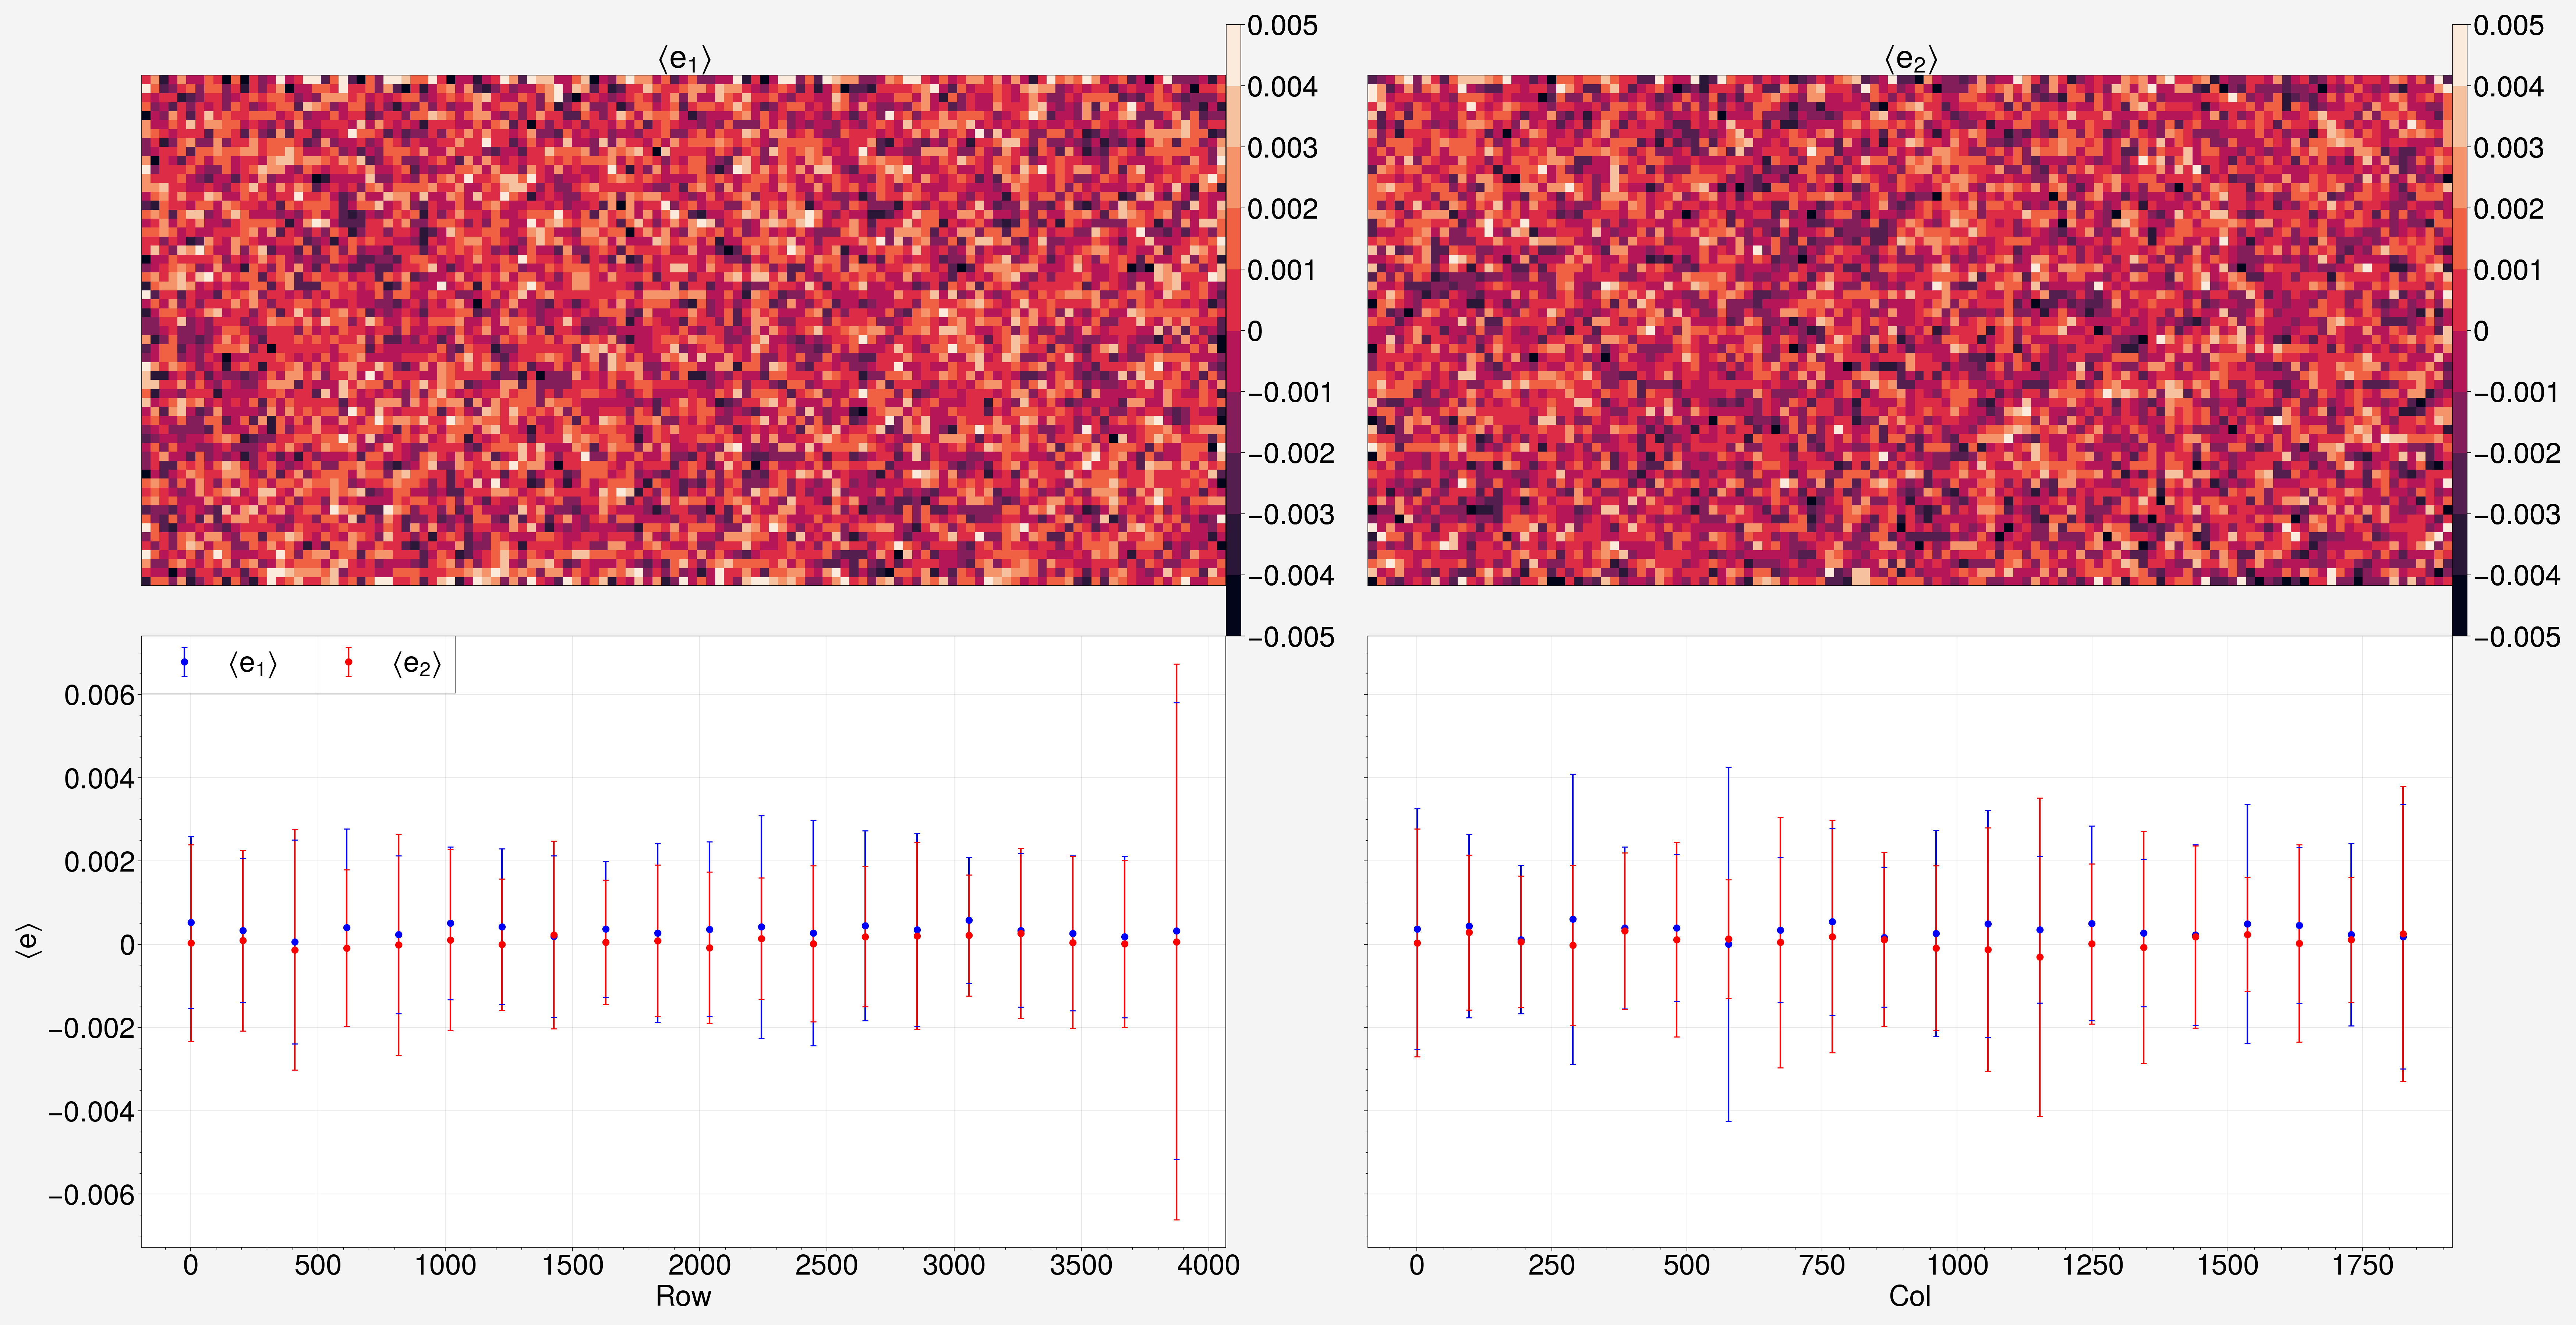

In [60]:

# Stacking 1-62 CCDs
mean_g1, mean_g2 = compute_shear_stack_CCDs(ccdres_all, x_side, y_side, stack_north_south=True)
# Trimming around the edges. 
mean_g1 = mean_g1[2:-2,2:-2]
mean_g2 = mean_g2[2:-2,2:-2]
    
g1_flat = mean_g1.flatten()
g2_flat = mean_g2.flatten()
print(g1_flat[g1_flat < -10], g2_flat[g2_flat < -10])

mpl.rcParams.update({'font.size': 28})
fig = pplt.figure(figsize=(35,18), sharex=False, sharey=True)
ax1 = fig.subplots(nrows=2,ncols=2)
cmap = plt.get_cmap('rocket')

piece_side = 32
X, Y = np.meshgrid(np.linspace(1, 3873, (3872//piece_side)+1), np.linspace(1, 1825, (1824//piece_side)+1))

mean = np.nanmean(mean_g1[mean_g1 > -10])
sig = np.nanstd(mean_g1[mean_g1 > -10]) / np.sqrt(mean_g1[mean_g1 > -10].size)
mesh = ax1[0,0].pcolormesh(X,Y,mean_g1, vmin=-0.005, vmax=0.005, cmap=cmap)
ax1[0,0].set_aspect(1)
ax1[0,0].set_title(r'$\langle e_{1} \rangle$')
ax1[0,0].set_xticks([])
ax1[0,0].set_yticks([])
plt.colorbar(mesh, ax=ax1[0,0], pad=0.01)

mean = np.nanmean(mean_g2[mean_g2 > -10])
sig = np.nanstd(mean_g2[mean_g2 > -10]) / np.sqrt(mean_g2[mean_g2 > -10].size)
mesh = ax1[0,1].pcolormesh(X,Y,mean_g2, vmin=-0.005, vmax=0.005, cmap=cmap)
ax1[0,1].set_aspect(1)
ax1[0,1].set_title(r'$\langle e_{2} \rangle$')
ax1[0,1].set_xticks([])
ax1[0,1].set_yticks([])
plt.colorbar(mesh, ax=ax1[0,1], pad=0.01)


# Jackknife error estimate.
with open('/global/cscratch1/sd/myamamot/metadetect/shear_variations/mean_shear_jk_cov_v2.pickle', 'rb') as jk:
    d_mean_shear = pickle.load(jk)

# With jackknife errors.
nbin = 20
x_ = np.linspace(1,3873,nbin)
y_ = np.linspace(1,1825,nbin)

ax1[1,0].errorbar(x_, d_mean_shear['x_g1'], yerr=d_mean_shear['jc_x_g1'], fmt='o', c='b', label=r'$\langle e_{1} \rangle$')
ax1[1,0].errorbar(x_, d_mean_shear['x_g2'], yerr=d_mean_shear['jc_x_g2'], fmt='o', c='r', label=r'$\langle e_{2} \rangle$')
ax1[1,0].set_xlabel('Row')
ax1[1,0].legend(loc='upper left')
ax1[1,0].set_ylabel(r'$\langle e \rangle$')

ax1[1,1].errorbar(y_, d_mean_shear['y_g1'], yerr=d_mean_shear['jc_y_g1'], fmt='o', c='b', label=r'$\langle e_{1} \rangle$')
ax1[1,1].errorbar(y_, d_mean_shear['y_g2'], yerr=d_mean_shear['jc_y_g2'], fmt='o', c='r', label=r'$\langle e_{2} \rangle$')
ax1[1,1].set_xlabel('Col')
# ax1[1,1].set_ylabel(r'$\langle e_{2} \rangle$')

plt.tight_layout()
plt.savefig('mdet_shear_variations_focal_plane_stacked_xy_v2.pdf', bbox_inches='tight')
plt.show()

# 3. Tangential shear around field centers

In [47]:
import treecorr
from scipy import linalg
ng = fio.read('/global/cscratch1/sd/myamamot/metadetect/field_centers/cross_correlation_output.fits')
ng_cov = np.load('/global/cscratch1/sd/myamamot/metadetect/field_centers/cross_correlation_cov.npy')

reduced chi2 with doagonal part of covariance matrix 26.480655721683295 dof 20
chi2 with full covariance matrix 6347.347504472418 dof 20


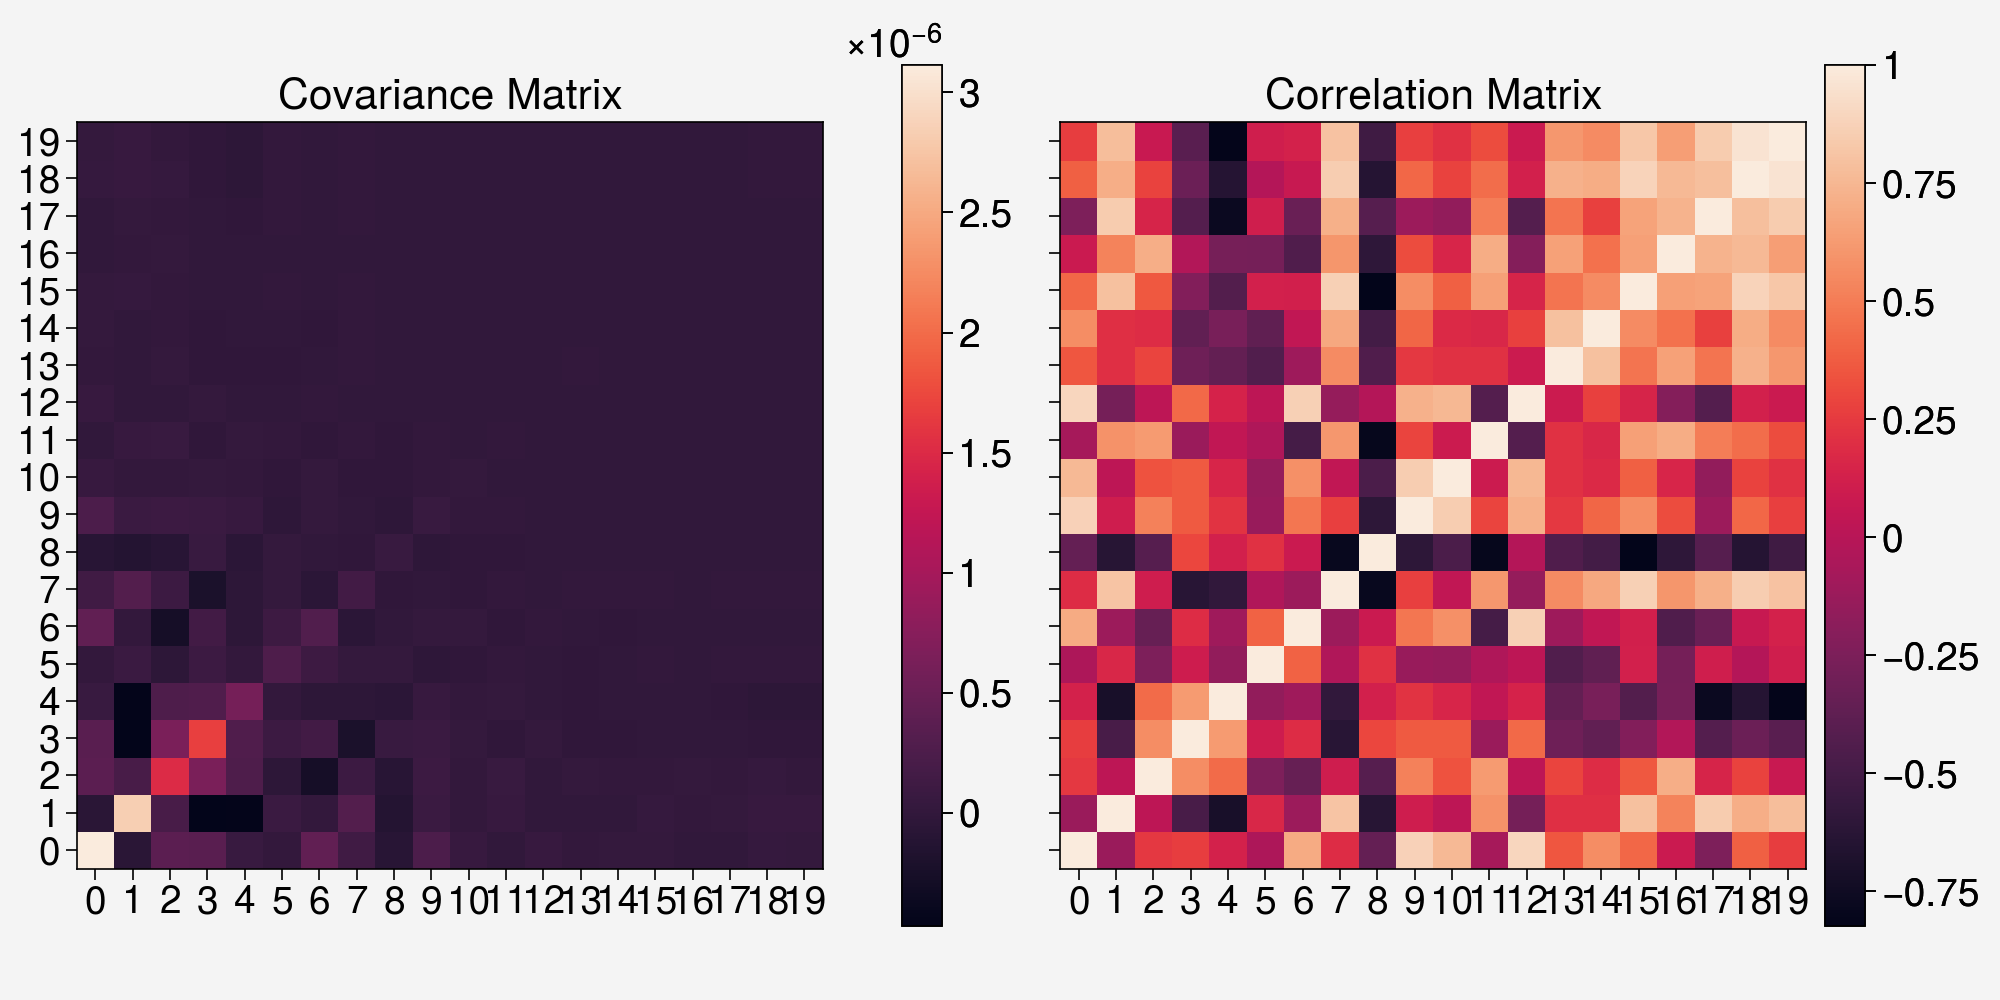

In [38]:
# Compute reduced chi2 from the diagonal part of covariances matrix. 
reduced_chi2 = np.sum(ng['gamT']**2 / ng['sigma']**2)
dof = ng.shape[0]
print('reduced chi2 with doagonal part of covariance matrix', reduced_chi2, 'dof', dof)

# Compute chi2 and p-value. 
c_inv = np.linalg.pinv(ng_cov)
chi2 = ng['gamT'].T @ c_inv @ ng['gamT']
print('chi2 with full covariance matrix', chi2, 'dof', dof)

mpl.rcParams.update({'font.size':14})
fig = pplt.figure(figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)

im = ax[0].heatmap(ng_cov, cmap='rocket')
ax[0].colorbar(im, loc='r')
ax[0].set_title('Covariance Matrix')
im2 = ax[1].heatmap(np.corrcoef(ng_cov), cmap='rocket')
ax[1].colorbar(im2, loc='r')
ax[1].set_title('Correlation Matrix')
plt.show()

<ipython-input-48-99f48132349f>:11: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


<Figure size 400x400 with 0 Axes>

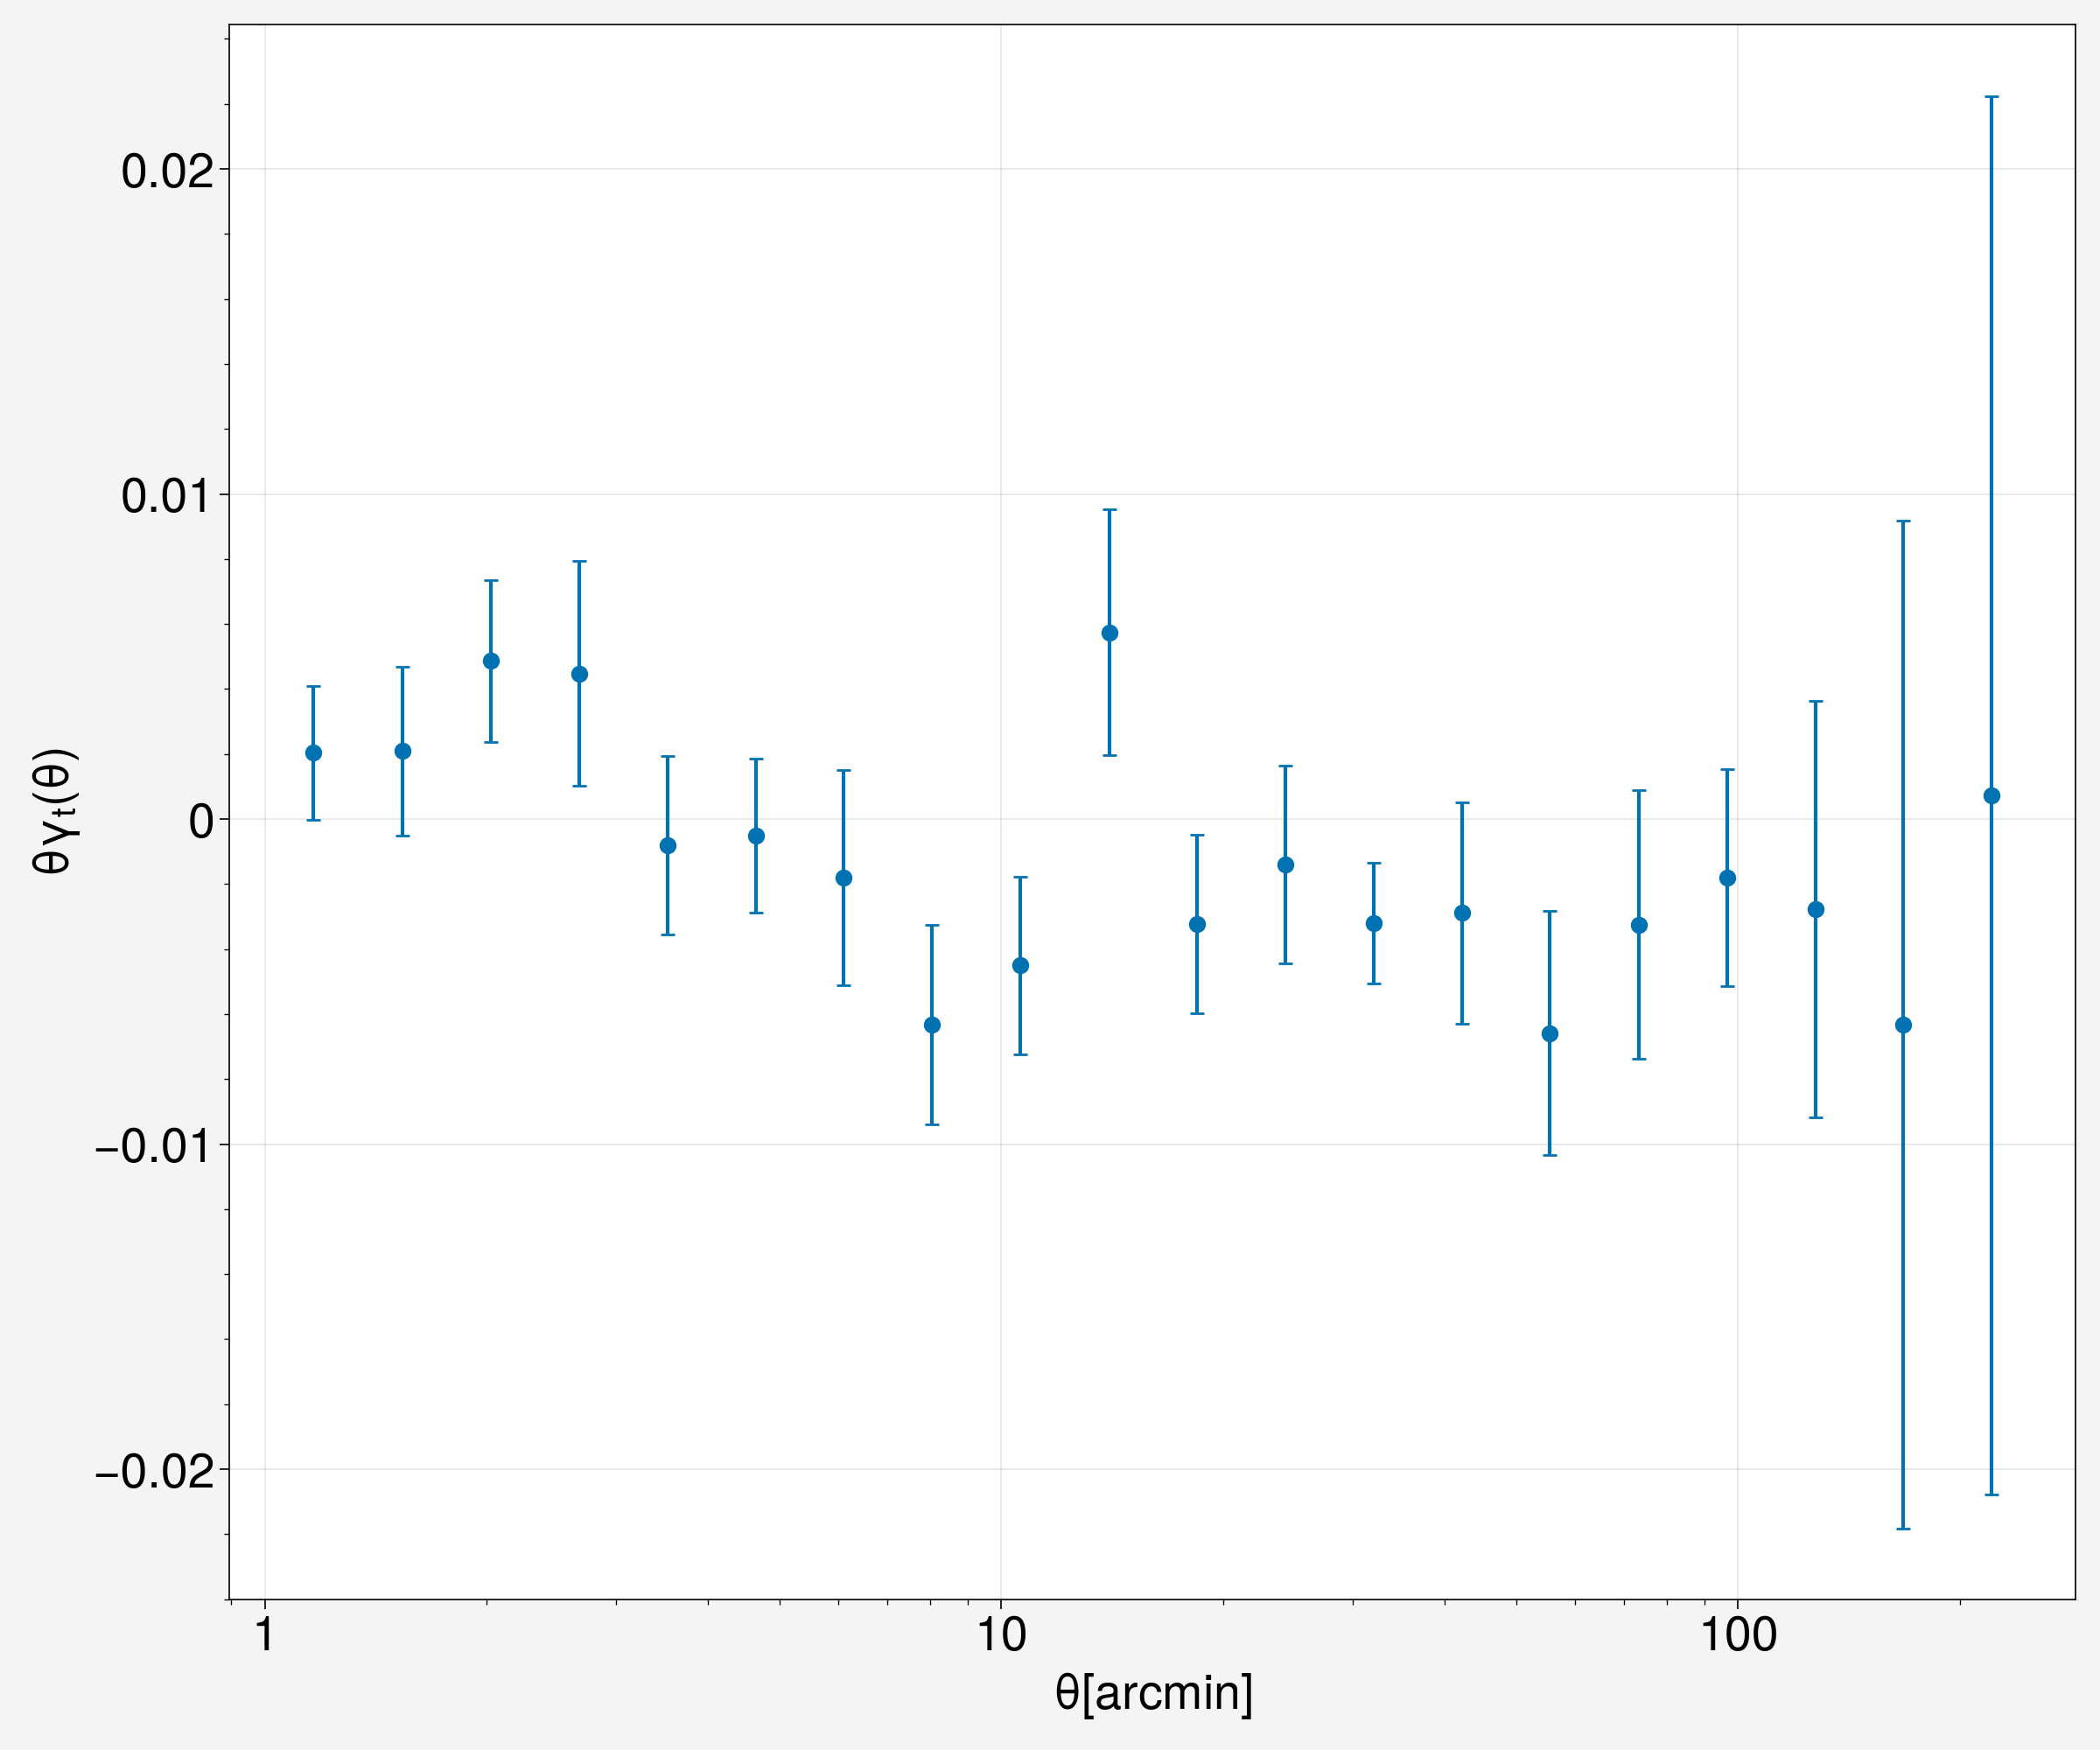

In [48]:
plt.clf()
mpl.rcParams.update({'font.size':20})
fig = pplt.figure(figsize=(12,10))
ax = fig.subplots()
ax.errorbar(ng['meanr'], ng['meanr']*ng['gamT'], yerr=ng['meanr']*ng['sigma'], fmt='o')
ax.set_ylabel(r'$\theta\gamma_{\rm t}(\theta)$')
ax.set_xlabel(r'$\theta [arcmin]$')
# ax.fill_between(ng['meanr'], -0.004, 0.004, color='grey', alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('tangential_shear_around_field_centers_v2.pdf', bbox_inches='tight')
fig.show()

# 4. Tangential/Cross-component shear around bright/faint stars. 

In [49]:
# measurement file
ng_bright = fio.read('/global/cscratch1/sd/myamamot/metadetect/stars_shear_cross_correlation_output_0.fits')
cov_bright = np.load('/global/cscratch1/sd/myamamot/metadetect/stars_shear_cross_correlation_cov_0.npy')
ng_faint = fio.read('/global/cscratch1/sd/myamamot/metadetect/stars_shear_cross_correlation_output_1.fits')
cov_faint = np.load('/global/cscratch1/sd/myamamot/metadetect/stars_shear_cross_correlation_cov_1.npy')

<ipython-input-51-083f524c5fd1>:23: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


<Figure size 400x400 with 0 Axes>

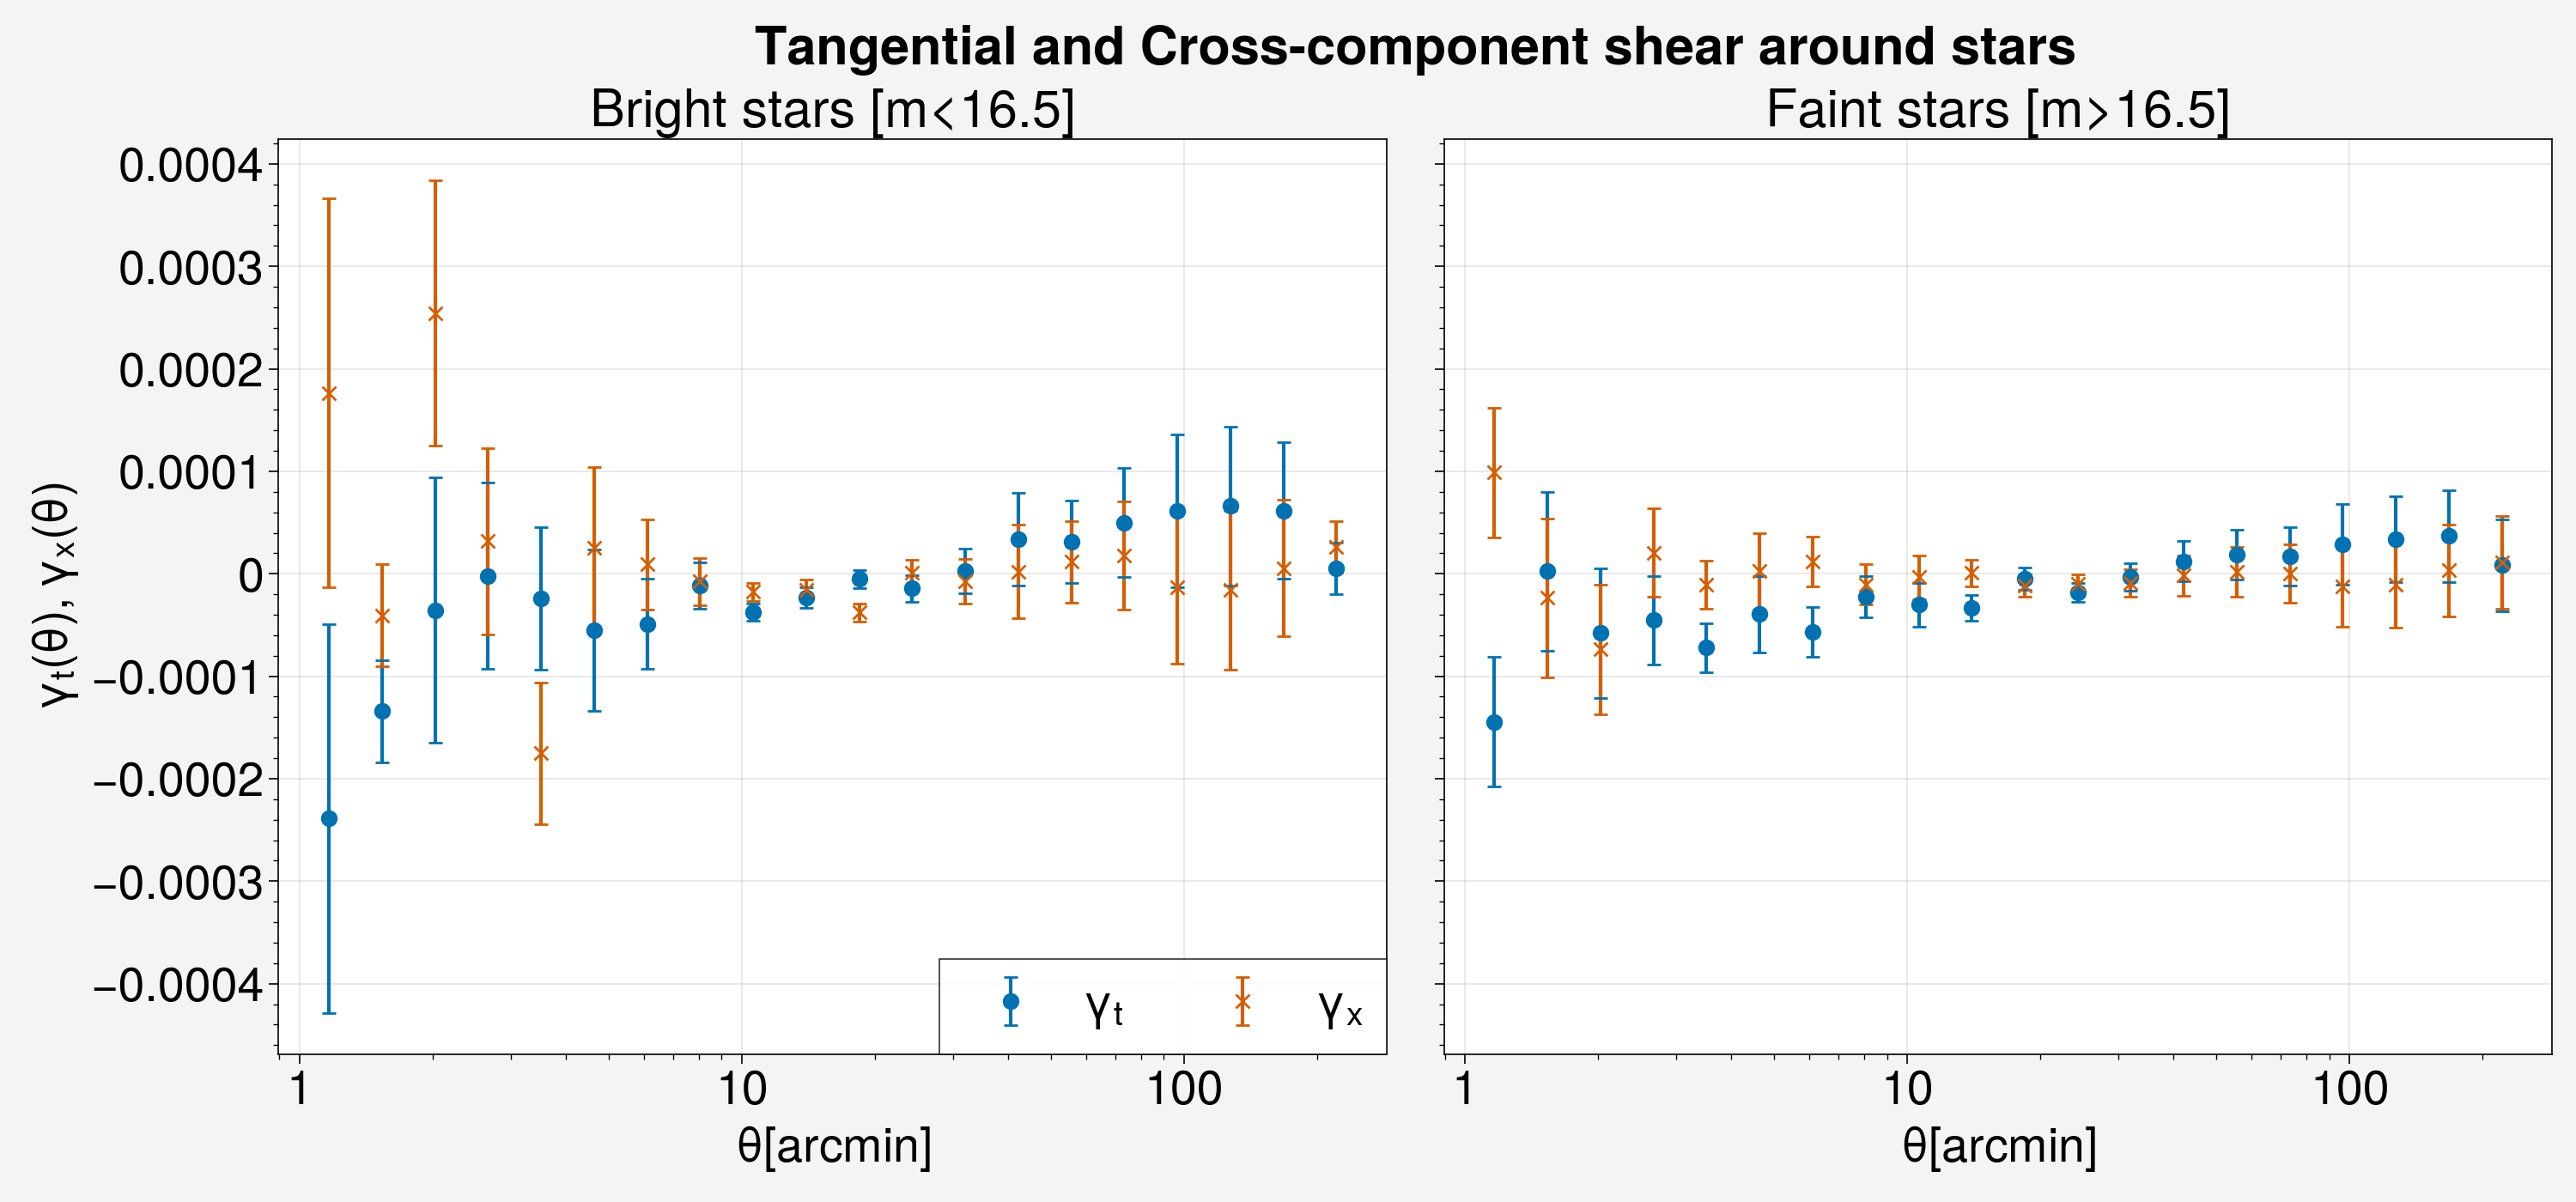

In [51]:
plt.clf()
mpl.rcParams.update({'font.size':20})
fig = pplt.figure(figsize=(15,7), sharex=False)
ax = fig.subplots(nrows=1, ncols=2)

ax[0].errorbar(ng_bright['meanr'], ng_bright['gamT'], yerr=ng_bright['sigma'], fmt='o', label=r'$\gamma_{\rm t}$')
ax[0].errorbar(ng_bright['meanr'], ng_bright['gamX'], yerr=ng_bright['sigma'], fmt='x', label=r'$\gamma_{\rm x}$')
ax[0].set_ylabel(r'$\gamma_{\rm t}(\theta), \gamma_{\rm x}(\theta)$')
ax[0].set_title('Bright stars [m<16.5]')
ax[0].legend(loc='lower right')
ax[0].set_xlabel(r'$\theta [arcmin]$')
ax[0].set_xscale('log')


ax[1].errorbar(ng_faint['meanr'], ng_faint['gamT'], yerr=ng_faint['sigma'], fmt='o', label=r'$\gamma_{\rm t}$')
ax[1].errorbar(ng_faint['meanr'], ng_faint['gamX'], yerr=ng_faint['sigma'], fmt='x', label=r'$\gamma_{\rm x}$')
ax[1].set_ylabel(r'$\gamma_{\rm t}(\theta), \gamma_{\rm x}(\theta)$')
ax[1].set_title('Faint stars [m>16.5]')
ax[1].set_xlabel(r'$\theta [arcmin]$')
ax[1].set_xscale('log')

fig.suptitle('Tangential and Cross-component shear around stars')
plt.tight_layout()
plt.savefig('tangential_shear_around_stars_v2.pdf', bbox_inches='tight')
plt.show()